In [1]:
!pip install datasets tqdm -q
from huggingface_hub import login
from datasets import load_dataset
from huggingface_hub import snapshot_download
import os
import sys
import torch
import os
import numpy as np
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
dataset_id="RayanAi/Main_teeth_dataset"
# Set the local directory where you want to store the dataset
local_dataset_dir = "/kaggle/working/"  # You can change this path to your desired location

# Create the directory if it doesn't exist
os.makedirs(local_dataset_dir, exist_ok=True)

# Suppress the output by redirecting it to os.devnull
with open(os.devnull, 'w') as fnull:
    # Save the original stdout
    original_stdout = sys.stdout
    try:
        # Redirect stdout to devnull to suppress output
        sys.stdout = fnull
        # Download the dataset and store it locally
        snapshot_download(repo_id=dataset_id, local_dir=local_dataset_dir, repo_type="dataset")
    finally:
        # Restore the original stdout
        sys.stdout = original_stdout

# Print message when download is complete
print("Dataset downloaded completely.")

# Calculate and print the total size of the downloaded files
total_size = 0
for dirpath, dirnames, filenames in os.walk(local_dataset_dir):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)

# Convert size to MB and print
print(f"Total size of downloaded files: {total_size / (1024 * 1024):.2f} MB")

# Get the absolute path of the dataset directory and print it
dataset_abs_path = os.path.abspath(local_dataset_dir)
print(f"Dataset has been saved at: [{dataset_abs_path}]")


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Main_teeth_dataset.zip:   0%|          | 0.00/90.2M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

Dataset downloaded completely.
Total size of downloaded files: 86.08 MB
Dataset has been saved at: [/kaggle/working]


In [3]:
!unzip -q /kaggle/working/Main_teeth_dataset.zip -d ./Main_teeth_dataset/

In [4]:
import os
from PIL import Image
import numpy as np

In [5]:
# Define paths to image and label directories
label_dir = "/kaggle/working/Main_teeth_dataset/labels"
image_dir = "/kaggle/working/Main_teeth_dataset/images"

In [6]:
# Define a variance threshold to identify noisy labels (adjust based on dataset)
variance_threshold = 5000  # Higher variance indicates salt-and-pepper noise

In [7]:
# List to track deleted files
deleted_files = []

for label_name in os.listdir(label_dir):
    if label_name.endswith('.png'):
        label_path = os.path.join(label_dir, label_name)
        image_path = os.path.join(image_dir, label_name)  # Assuming the same name in images folder

        # Open the label image and convert to grayscale
        label_image = Image.open(label_path).convert("L")
        label_array = np.array(label_image)

        # Calculate variance
        pixel_variance = np.var(label_array)

        # If variance is higher than the threshold, delete label and corresponding image
        if pixel_variance > variance_threshold:
            os.remove(label_path)  # Delete the label file
            if os.path.exists(image_path):
                os.remove(image_path)  # Delete the corresponding image file if it exists

            # Track deleted files
            deleted_files.append((label_name, label_path, image_path))

print(f"Deleted {len(deleted_files)} noisy label-image pairs.")

Deleted 206 noisy label-image pairs.


In [8]:
#Define the split ratio
split_ratio = 0.8

In [9]:
!pip install natsort

In [10]:
import os
import pathlib
import natsort
import numpy as np
import torch
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

In [11]:
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose, dataset_type: str = 'Train', noisy_masks: list = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            mask_dir (str): Directory path containing corresponding segmentation masks.
            transform (callable): Optional transformation to be applied to both the image and the mask. Use A.Compose. Use ToTensorV2()
            dataset_type (str, optional): Type of dataset, e.g., 'Train' or 'Test'. Defaults to 'Train'.
            noisy_masks (list, optional): Provide a list of names for images you want to be excluded from dataset
        """
        # Initialize paths and transformation
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.dataset_type = dataset_type

        # List of all images and masks
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        # Filter out noisy masks if provided
        if noisy_masks:
            self.images = [img for img in self.images if img not in noisy_masks]
            self.masks = [mask for mask in self.masks if mask not in noisy_masks]
        number_of_samples = len(self.images)

        if dataset_type == 'Train':
            self.images = self.images[:int(number_of_samples*split_ratio)]
            self.masks = self.masks[:int(number_of_samples*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.images[int(number_of_samples*split_ratio):]
            self.masks = self.masks[int(number_of_samples*split_ratio):]



    def __len__(self) -> int:
        """
        Returns:
            int: The total number of image-mask pairs in the designated dataset split.
        """
        # Return the length of the dataset (number of images)
        return len(self.images)


    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            index (int): Index of the image-mask pair to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the image and its corresponding one-hot encoded mask.
                - image (torch.Tensor): Transformed image tensor.
                - mask (torch.Tensor): Mask tensor for segmentation.
        """
        # Load the image and mask
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        # Load image and mask as grayscale
        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        binary_mask = mask.unsqueeze(2)>0
        binary_mask = binary_mask.permute(2, 0, 1).float()

        return image, binary_mask

In [12]:
augmenter = A.Compose([    
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),    
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),    
    A.Rotate(limit=20, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),    
    A.ElasticTransform(alpha=1.0, sigma=50.0, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),    
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),])

In [13]:
test_augmenter = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])

In [14]:
train_dataset = TeethSegmentationDataset(
    image_dir="/kaggle/working/Main_teeth_dataset/images",
    mask_dir="/kaggle/working/Main_teeth_dataset/labels",
    transform=augmenter,
    dataset_type='Train',

)

In [15]:
test_dataset = TeethSegmentationDataset(
    image_dir="/kaggle/working/Main_teeth_dataset/images",
    mask_dir="/kaggle/working/Main_teeth_dataset/labels",
    transform=test_augmenter,
    dataset_type='Test',

)

In [16]:
batch_size=8
num_workers=4 # Increase this if you have a powerfull cpu
dataloaders = {
  'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
  'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 317
Test dataset size: 80


In [17]:
# Get a batch of training data
images, masks = next(iter(dataloaders['train']))

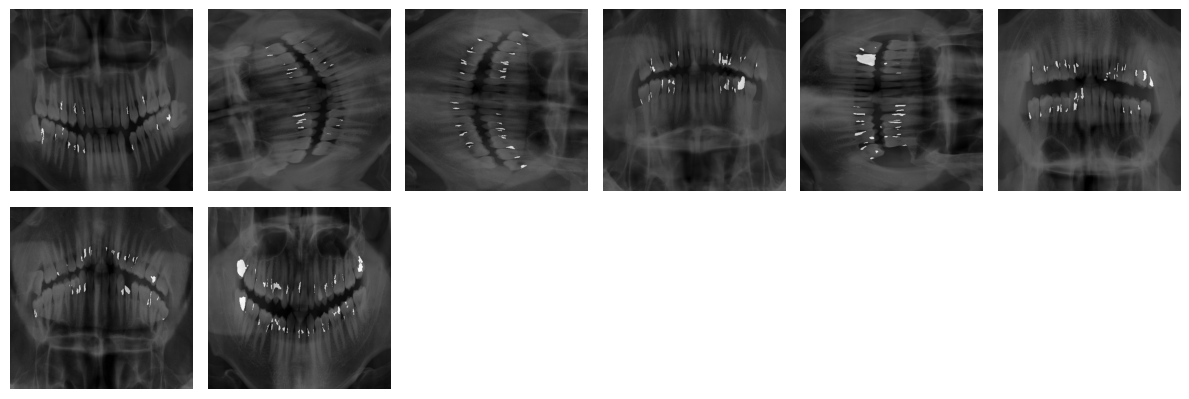

In [18]:
# Plot the images and masks
plt.figure(figsize=(12, 12))
for i in range(36):
    # If we have fewer than 36 images in the batch, break the loop
    if i >= len(images):
        break
    plt.subplot(6, 6, i + 1)
    # Move the image tensor to the CPU and convert it to a numpy array
    image = images[i].permute(1, 2, 0).cpu().numpy()
    mask = masks[i].squeeze().cpu().numpy()  # Assuming mask has shape (1, H, W)

    # Display the image in grayscale
    plt.imshow(image, cmap='gray')
    # Overlay the mask with some transparency
    plt.imshow(mask, alpha=0.6, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation='relu', conv_type='encoder'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm1 = nn.GroupNorm(num_groups=out_channels, num_channels=out_channels)
        self.activation = getattr(F, activation.lower())  # Use functional activation for flexibility

        self.conv_type = conv_type
        if conv_type == 'decoder':
            self.conv2 = nn.Conv2d(out_channels, out_channels * 2, kernel_size, stride, padding)
            self.norm2 = nn.GroupNorm(num_groups=out_channels * 2, num_channels=out_channels * 2)
            self.conv3 = nn.Conv2d(out_channels * 2, out_channels, kernel_size, stride, padding)
            self.norm3 = nn.GroupNorm(num_groups=out_channels, num_channels=out_channels)
        
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding='same')

    def forward(self, x):
        out = self.activation(self.norm1(self.conv1(x)))
        if self.conv_type == 'decoder':
            out = self.activation(self.norm2(self.conv2(out)))
            out = self.activation(self.norm3(self.conv3(out)))

        # Residual connection
        residual = self.residual(x)
        out = out + residual
        out = self.activation(out)
        return out


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation='relu'):
        super().__init__()
        self.conv_block = ConvolutionBlock(in_channels, out_channels, kernel_size, stride, padding, activation)
        self.pool = nn.AvgPool2d(kernel_size=2)
        
    def forward(self, x):
        out = self.conv_block(x)
        downsampled = self.pool(out)
        # print(f"Encoder output shape: {out.shape}") 
        return downsampled, out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation='relu'):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=padding)
        self.conv_block = ConvolutionBlock(out_channels, out_channels, kernel_size, stride, padding, activation, conv_type='decoder')

    def forward(self, x, skip_connection):
        x = self.upconv(x)
        # print(f"Upconv output shape: {x.shape}")  # Print after upsampling
        # print(f"Skip connection shape: {skip_connection.shape}")  # Print skip connection shape
        # Ensure matching dimensions before addition
        if x.shape[2:] != skip_connection.shape[2:]:
            # print("Interpolating upconv output to match skip connection size.")
            x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)
        x = (x + skip_connection) / 2  # Averaging as skip connection
        out = self.conv_block(x)
        return out


class Generator(nn.Module):
    def __init__(self, in_channels, base_filters, kernel_size, stride, padding):
        super().__init__()
        self.encoder1 = EncoderBlock(in_channels, base_filters, kernel_size, stride, padding, 'leaky_relu')
        self.encoder2 = EncoderBlock(base_filters, base_filters * 2, kernel_size, stride, padding, 'leaky_relu')
        self.encoder3 = EncoderBlock(base_filters * 2, base_filters * 4, kernel_size, stride, padding, 'leaky_relu')
        self.encoder4 = EncoderBlock(base_filters * 4, base_filters * 8, kernel_size, stride, padding, 'leaky_relu')
        self.encoder5 = EncoderBlock(base_filters * 8, base_filters * 16, kernel_size, stride, padding, 'leaky_relu')

        self.decoder1 = DecoderBlock(base_filters * 16, base_filters * 16, kernel_size, stride, padding)
        self.decoder2 = DecoderBlock(base_filters * 8, base_filters * 8, kernel_size, stride, padding)
        self.decoder3 = DecoderBlock(base_filters * 8, base_filters * 4, kernel_size, stride, padding)
        self.decoder4 = DecoderBlock(base_filters * 4, base_filters * 2, kernel_size, stride, padding)
        self.decoder5 = DecoderBlock(base_filters * 2, base_filters, kernel_size, stride, padding)

        self.output_layer = nn.ConvTranspose2d(base_filters, 1, kernel_size=kernel_size, stride=stride, padding=padding)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        con1, skip1 = self.encoder1(x)
        con2, skip2 = self.encoder2(con1)
        con3, skip3 = self.encoder3(con2)
        con4, skip4 = self.encoder4(con3)
        con5, skip5 = self.encoder5(con4)

        deco = self.decoder1(con5, skip5)
        deco1 = self.decoder2(con4, skip4)
        deco2 = self.decoder3(deco1, skip3)
        deco3 = self.decoder4(deco2, skip2)
        deco4 = self.decoder5(deco3, skip1)

        output = self.sigmoid(self.output_layer(deco4))
        return output

class Model(nn.Module):
    def __init__(self, in_channels=1, base_filters=32, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.generator = Generator(in_channels, base_filters, kernel_size, stride, padding)

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        This method defines the forward pass of the GAN.
        Args:
            image (tensor): The input tensor, in the shape of (batch_size, 1, 512, 512).
        Returns:
            tensor: Generated mask.
        """
        generated_mask = self.generator(image)
        return generated_mask

In [31]:
model = Model().to(device)

In [32]:
image, mask = next(iter(dataloaders['train']))  # Get both image and mask from the data loader
image = image.to(device)
mask = mask.to(device)

In [33]:
out = model(image)

In [34]:
print(image.shape)
print(out.shape)
assert image.shape == (batch_size, 1, 512, 512), "You shouldn't change the size of the image"
assert out.shape == (batch_size, 1, 512, 512), "The output of your model do not have correct dimensions"

torch.Size([8, 1, 512, 512])
torch.Size([8, 1, 512, 512])


In [35]:
def dice_score(pred: torch.Tensor, target_mask: torch.Tensor, epsilon: float = 1e-6) -> float:
    """
    Computes the Dice score between the predicted and target segmentation masks.

    Args:
        pred (torch.Tensor): The predicted mask tensor, with values in range [0, 1].
        target_one_target_maskhot (torch.Tensor): The ground truth mask.
        epsilon (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

    Returns:
        float: The Dice score, a similarity metric between 0 and 1.
    """
    pred = pred>0
    pred_flat = pred.contiguous().view(pred.shape[0], pred.shape[1], -1)
    target_flat = target_mask.contiguous().view(target_mask.shape[0], target_mask.shape[1], -1)

    intersection = (pred_flat * target_flat).sum(dim=-1)
    union = pred_flat.sum(dim=-1) + target_flat.sum(dim=-1)

    dice = (2. * intersection + epsilon) / (union + epsilon)

    dice_mean = dice.mean(dim=1)

    return dice_mean.mean()

In [36]:
def visualize_mask(inputs: torch.Tensor, masks: torch.Tensor, outputs: torch.Tensor):
    # Convert tensors to numpy for visualization
    sample_index = 0  # Index of the sample to visualize
    channel = 0
    print(f'Dice score is {dice_score(outputs[sample_index:sample_index+1,channel:channel+1],masks[sample_index:sample_index+1,channel:channel+1])}')

    inputs_np = inputs.cpu().numpy()
    masks_np = masks.cpu().numpy()
    outputs_np = (outputs.detach().cpu().numpy() > 0.5).astype(float)


    # Choose a sample to visualize

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(inputs_np[sample_index].transpose(1, 2, 0), cmap='gray')  # Assuming inputs are in CxHxW format
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks_np[sample_index, channel], cmap='gray')  # Display the first channel of the mask
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(outputs_np[sample_index, channel]>0, cmap='gray')  # Display the first channel of the output
    plt.title("Model Output Mask")
    plt.axis('off')

    plt.show()

In [37]:
import torch
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn

def dice_coef(y_true, y_pred, smooth=1e-6):
    """Calculate Dice coefficient."""
    intersection = (y_true * y_pred).sum()
    return (2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    """Calculate Dice loss."""
    return 1 - dice_coef(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=1e-6):
    """Calculate Jaccard distance loss."""
    intersection = (y_true * y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    return 1 - (intersection + smooth) / (total - intersection + smooth)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, smooth=1e-6):
    """Calculate Focal loss."""
    bce_loss = F.binary_cross_entropy(y_pred, y_true, reduction='none')
    p_t = torch.exp(-bce_loss)  # Probabilities
    focal_loss_value = alpha * (1 - p_t) ** gamma * bce_loss
    return focal_loss_value.mean()

def combined_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    """Combine Dice and Focal losses."""
    return alpha * dice_coef_loss(y_true, y_pred) + beta * focal_loss(y_true, y_pred)

def train_model(
    generator: nn.Module,
    dataloaders: dict[str, torch.utils.data.DataLoader],
    optimizer_G: torch.optim.Optimizer,
    scheduler_G,
    num_epochs: int = 25,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    save_dir: str = './model_checkpoints'
) -> nn.Module:
    """Trains the generator model, saving the best weights based on Dice score."""
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    since = time.time()
    best_dice_score = 0.0

    train_losses_G = []  
    dice_scores_epoch = []  

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            generator.train() if phase == 'train' else generator.eval()
            running_loss_G = 0.0
            dice_scores = []

            for inputs, masks in tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase', leave=False):
                inputs = inputs.to(device)
                masks = masks.to(device)

                # Use no_grad() during testing to save memory
                with torch.no_grad() if phase == 'test' else torch.enable_grad():
                    # ================== Generator Forward Pass ==================
                    optimizer_G.zero_grad()

                    outputs = generator(inputs)

                    # Calculate combined loss
                    loss_G = combined_loss(masks, outputs)

                    if phase == 'train':
                        loss_G.backward()
                        optimizer_G.step()

                    running_loss_G += loss_G.item() * inputs.size(0)
                    
                    # Calculate Dice score for the batch
                    dice_scores.append(dice_coef(masks, outputs).item())

                # Clear any cache after each batch if needed
                torch.cuda.empty_cache()

            # Calculate epoch loss and Dice score
            epoch_loss_G = running_loss_G / len(dataloaders[phase].dataset)
            mean_dice_score = torch.tensor(dice_scores).mean().item()
            dice_scores_epoch.append(mean_dice_score)

            print(f'{phase.capitalize()} Loss (G): {epoch_loss_G:.4f} | Dice Score: {mean_dice_score:.4f}')
                
            # Check if this is the best model so far
            if phase == 'test' and mean_dice_score > best_dice_score:
                best_dice_score = mean_dice_score
                # Save the best model
                torch.save({
                    'epoch': epoch + 1,
                    'generator_state_dict': generator.state_dict(),
                    'optimizer_G_state_dict': optimizer_G.state_dict(),
                    'best_dice_score': best_dice_score
                }, f"{save_dir}/best_generator_model.pth")
                print(f'Best model saved with Dice score: {best_dice_score:.4f}')
        
            scheduler_G.step()
        
            if epoch % 3 == 0:
                # Visualize results after each epoch
                visualize_mask(inputs, masks, outputs)

    # Print total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Plot loss and Dice score
    epochs_range = range(num_epochs)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses_G, label="Generator Train Loss")
    plt.legend(loc="upper right")
    plt.title("Generator Training Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, dice_scores_epoch, label="Dice Score", color="green")
    plt.legend(loc="lower right")
    plt.title("Dice Score")

    plt.show()

    return generator


In [38]:
import torch.nn as nn

# Define the loss functions for the generator
criterion_G = [
    nn.BCELoss(),               # Binary cross-entropy for reconstruction loss
    nn.KLDivLoss(reduction="batchmean"),  # KL Divergence loss
    # Add Dice loss in the main loop calculation if custom or calculate separately
]

# Define initial learning rates, weight decay, and scheduler settings
learning_rate = 0.001
weight_decay = 6e-8
step_size = 100  # Reduce LR every 100 epochs
gamma = 0.5  # Multiply LR by 0.5 every `step_size` epochs

# Initialize RMSprop optimizer with weight decay for the generator
optimizer_G = torch.optim.RMSprop(
    model.generator.parameters(),
    lr=learning_rate,  # Generator learning rate
    weight_decay=weight_decay  # Generator weight decay
)

# Add learning rate scheduler for the generator optimizer
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=step_size, gamma=gamma)


In [39]:
import time

In [40]:
import torch
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn

def dice_coef(y_true, y_pred, smooth=1e-6):
    """Calculate Dice coefficient."""
    intersection = (y_true * y_pred).sum()
    return (2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    """Calculate Dice loss."""
    return 1 - dice_coef(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=1e-6):
    """Calculate Jaccard distance loss."""
    intersection = (y_true * y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    return 1 - (intersection + smooth) / (total - intersection + smooth)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, smooth=1e-6):
    """Calculate Focal loss."""
    bce_loss = F.binary_cross_entropy(y_pred, y_true, reduction='none')
    p_t = torch.exp(-bce_loss)  # Probabilities
    focal_loss_value = alpha * (1 - p_t) ** gamma * bce_loss
    return focal_loss_value.mean()

def combined_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    """Combine Dice and Focal losses."""
    return alpha * dice_coef_loss(y_true, y_pred) + beta * focal_loss(y_true, y_pred)

def train_model(
    generator: nn.Module,
    dataloaders: dict[str, torch.utils.data.DataLoader],
    optimizer_G: torch.optim.Optimizer,
    scheduler_G,
    num_epochs: int = 25,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    save_dir: str = './model_checkpoints'
) -> nn.Module:
    """Trains the generator model, saving the best weights based on Dice score."""
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    since = time.time()
    best_dice_score = 0.0

    train_losses_G = []  
    dice_scores_epoch = []  

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            generator.train() if phase == 'train' else generator.eval()
            running_loss_G = 0.0
            dice_scores = []

            for inputs, masks in tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase', leave=False):
                inputs = inputs.to(device)
                masks = masks.to(device)

                # Use no_grad() during testing to save memory
                with torch.no_grad() if phase == 'test' else torch.enable_grad():
                    # ================== Generator Forward Pass ==================
                    optimizer_G.zero_grad()

                    outputs = generator(inputs)

                    # Calculate combined loss
                    loss_G = combined_loss(masks, outputs)

                    if phase == 'train':
                        loss_G.backward()
                        optimizer_G.step()

                    running_loss_G += loss_G.item() * inputs.size(0)
                    
                    # Calculate Dice score for the batch
                    dice_scores.append(dice_coef(masks, (outputs > 0.5).float()).item())

                # Clear any cache after each batch if needed
                torch.cuda.empty_cache()

            # Calculate epoch loss and Dice score
            epoch_loss_G = running_loss_G / len(dataloaders[phase].dataset)
            mean_dice_score = torch.tensor(dice_scores).mean().item()
            dice_scores_epoch.append(mean_dice_score)

            print(f'{phase.capitalize()} Loss (G): {epoch_loss_G:.4f} | Dice Score: {mean_dice_score:.4f}')
                
            # Check if this is the best model so far
            if phase == 'test' and mean_dice_score > best_dice_score:
                best_dice_score = mean_dice_score
                # Save the best model
                torch.save({
                    'epoch': epoch + 1,
                    'generator_state_dict': generator.state_dict(),
                    'optimizer_G_state_dict': optimizer_G.state_dict(),
                    'best_dice_score': best_dice_score
                }, f"{save_dir}/best_generator_model.pth")
                print(f'Best model saved with Dice score: {best_dice_score:.4f}')
        
            scheduler_G.step()
        
            if epoch % 10 == 0:
                # Visualize results after each epoch
                visualize_mask(inputs, masks, outputs)

    # Print total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Plot loss and Dice score
    epochs_range = range(num_epochs)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses_G, label="Generator Train Loss")
    plt.legend(loc="upper right")
    plt.title("Generator Training Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, dice_scores_epoch, label="Dice Score", color="green")
    plt.legend(loc="lower right")
    plt.title("Dice Score")

    plt.show()

    return generator


Epoch 1/400
----------


Train Loss (G): 0.4867 | Dice Score: 0.0390
Dice score is 0.019392505288124084


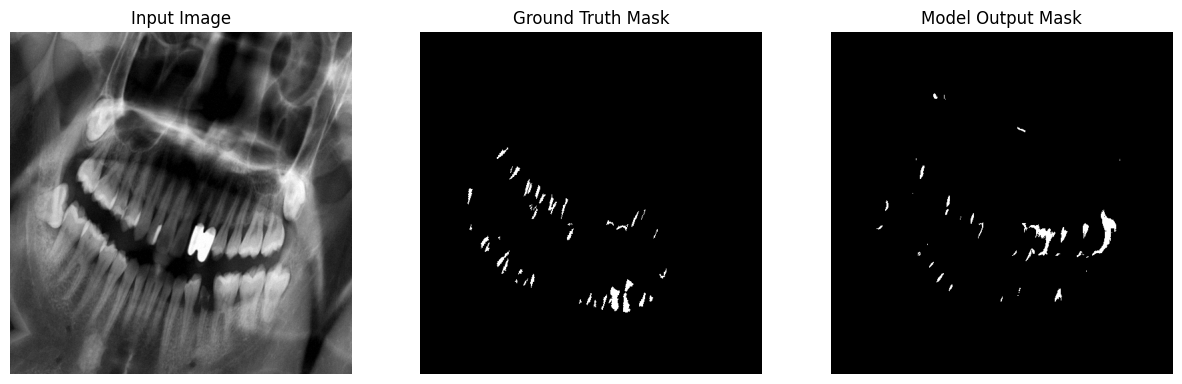

Test Loss (G): 0.4615 | Dice Score: 0.1118
Best model saved with Dice score: 0.1118
Dice score is 0.02431817166507244


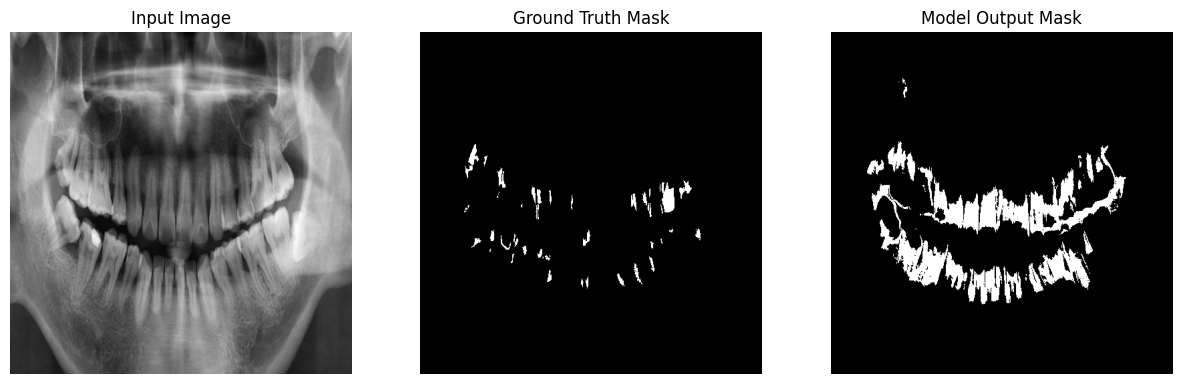

Epoch 2/400
----------


Train Loss (G): 0.4522 | Dice Score: 0.1222


Test Loss (G): 0.4373 | Dice Score: 0.1533
Best model saved with Dice score: 0.1533
Epoch 3/400
----------


Train Loss (G): 0.4314 | Dice Score: 0.1646


Test Loss (G): 0.4248 | Dice Score: 0.1846
Best model saved with Dice score: 0.1846
Epoch 4/400
----------


Train Loss (G): 0.4114 | Dice Score: 0.2066


Test Loss (G): 0.4011 | Dice Score: 0.2265
Best model saved with Dice score: 0.2265
Epoch 5/400
----------


Train Loss (G): 0.3882 | Dice Score: 0.2504


Test Loss (G): 0.3707 | Dice Score: 0.2827
Best model saved with Dice score: 0.2827
Epoch 6/400
----------


Train Loss (G): 0.3801 | Dice Score: 0.2654


Test Loss (G): 0.3625 | Dice Score: 0.2957
Best model saved with Dice score: 0.2957
Epoch 7/400
----------


Train Loss (G): 0.3633 | Dice Score: 0.2966


Test Loss (G): 0.3397 | Dice Score: 0.3456
Best model saved with Dice score: 0.3456
Epoch 8/400
----------


Train Loss (G): 0.3627 | Dice Score: 0.2979


Test Loss (G): 0.3472 | Dice Score: 0.3244
Epoch 9/400
----------


Train Loss (G): 0.3487 | Dice Score: 0.3246


Test Loss (G): 0.3488 | Dice Score: 0.3214
Epoch 10/400
----------


Train Loss (G): 0.3490 | Dice Score: 0.3244


Test Loss (G): 0.3583 | Dice Score: 0.3057
Epoch 11/400
----------


Train Loss (G): 0.3428 | Dice Score: 0.3364
Dice score is 0.008745118044316769


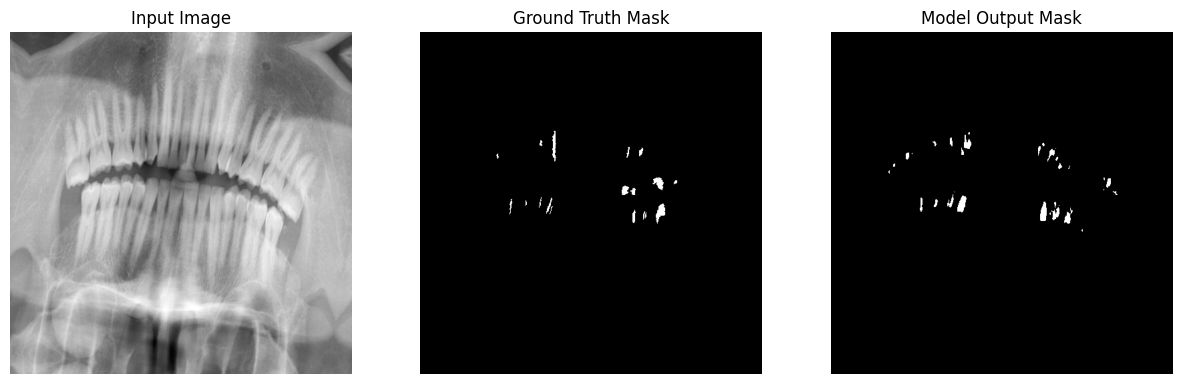

Test Loss (G): 0.3305 | Dice Score: 0.3619
Best model saved with Dice score: 0.3619
Dice score is 0.024437634274363518


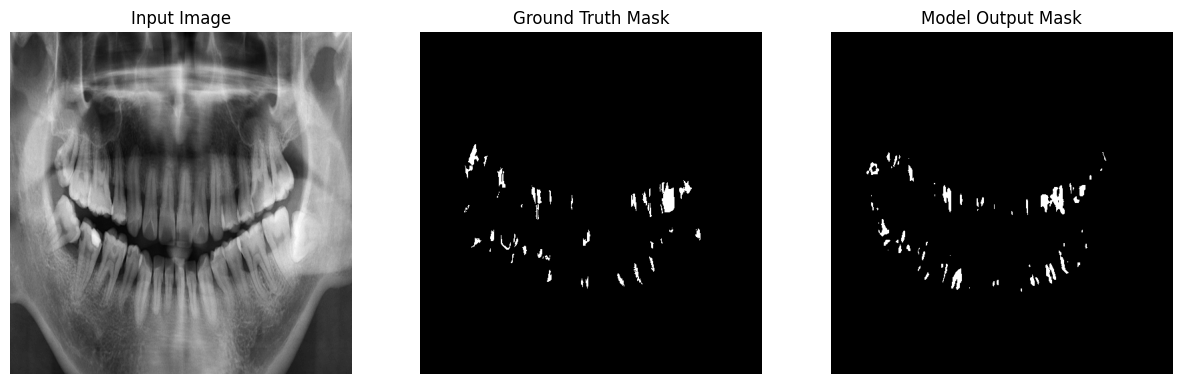

Epoch 12/400
----------


Train Loss (G): 0.3350 | Dice Score: 0.3519


Test Loss (G): 0.3283 | Dice Score: 0.3661
Best model saved with Dice score: 0.3661
Epoch 13/400
----------


Train Loss (G): 0.3327 | Dice Score: 0.3571


Test Loss (G): 0.3251 | Dice Score: 0.3698
Best model saved with Dice score: 0.3698
Epoch 14/400
----------


Train Loss (G): 0.3328 | Dice Score: 0.3558


Test Loss (G): 0.3233 | Dice Score: 0.3769
Best model saved with Dice score: 0.3769
Epoch 15/400
----------


Train Loss (G): 0.3237 | Dice Score: 0.3751


Test Loss (G): 0.3079 | Dice Score: 0.4032
Best model saved with Dice score: 0.4032
Epoch 16/400
----------


Train Loss (G): 0.3203 | Dice Score: 0.3810


Test Loss (G): 0.3052 | Dice Score: 0.4099
Best model saved with Dice score: 0.4099
Epoch 17/400
----------


Train Loss (G): 0.3186 | Dice Score: 0.3854


Test Loss (G): 0.3000 | Dice Score: 0.4186
Best model saved with Dice score: 0.4186
Epoch 18/400
----------


Train Loss (G): 0.3138 | Dice Score: 0.3941


Test Loss (G): 0.3136 | Dice Score: 0.3893
Epoch 19/400
----------


Train Loss (G): 0.3083 | Dice Score: 0.4048


Test Loss (G): 0.3191 | Dice Score: 0.3954
Epoch 20/400
----------


Train Loss (G): 0.3111 | Dice Score: 0.4020


Test Loss (G): 0.3068 | Dice Score: 0.4051
Epoch 21/400
----------


Train Loss (G): 0.3030 | Dice Score: 0.4182
Dice score is 0.01596902124583721


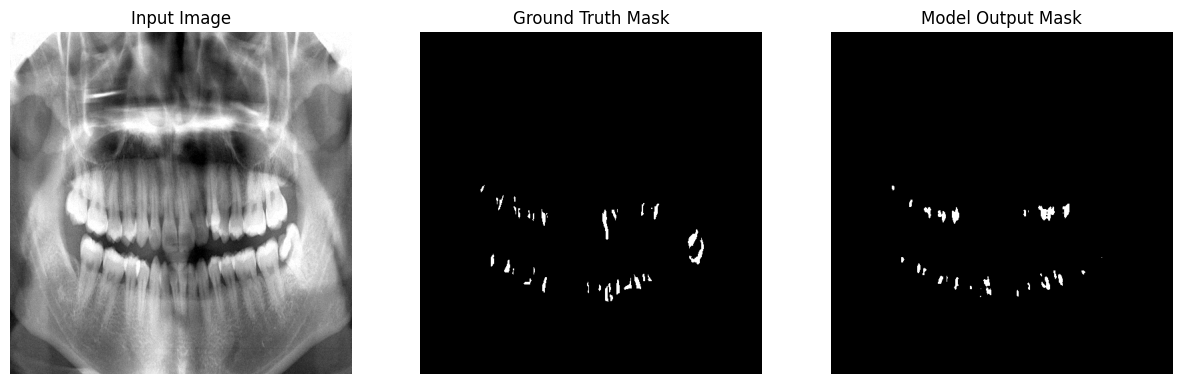

Test Loss (G): 0.2970 | Dice Score: 0.4265
Best model saved with Dice score: 0.4265
Dice score is 0.024402696639299393


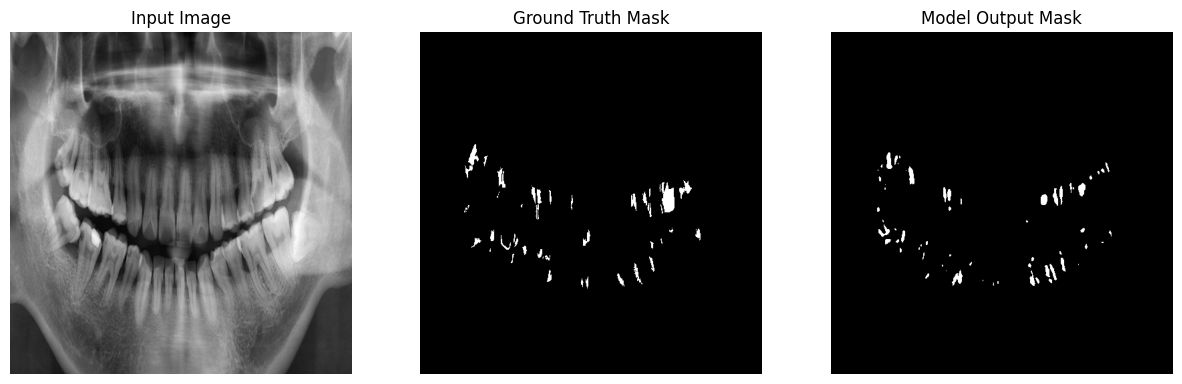

Epoch 22/400
----------


Train Loss (G): 0.3010 | Dice Score: 0.4220


Test Loss (G): 0.2830 | Dice Score: 0.4570
Best model saved with Dice score: 0.4570
Epoch 23/400
----------


Train Loss (G): 0.2992 | Dice Score: 0.4263


Test Loss (G): 0.2837 | Dice Score: 0.4613
Best model saved with Dice score: 0.4613
Epoch 24/400
----------


Train Loss (G): 0.2981 | Dice Score: 0.4287


Test Loss (G): 0.2843 | Dice Score: 0.4572
Epoch 25/400
----------


Train Loss (G): 0.2934 | Dice Score: 0.4373


Test Loss (G): 0.2774 | Dice Score: 0.4678
Best model saved with Dice score: 0.4678
Epoch 26/400
----------


Train Loss (G): 0.2915 | Dice Score: 0.4390


Test Loss (G): 0.2891 | Dice Score: 0.4540
Epoch 27/400
----------


Train Loss (G): 0.2923 | Dice Score: 0.4386


Test Loss (G): 0.3268 | Dice Score: 0.3700
Epoch 28/400
----------


Train Loss (G): 0.2989 | Dice Score: 0.4257


Test Loss (G): 0.2876 | Dice Score: 0.4410
Epoch 29/400
----------


Train Loss (G): 0.2845 | Dice Score: 0.4543


Test Loss (G): 0.2755 | Dice Score: 0.4744
Best model saved with Dice score: 0.4744
Epoch 30/400
----------


Train Loss (G): 0.2864 | Dice Score: 0.4509


Test Loss (G): 0.2943 | Dice Score: 0.4422
Epoch 31/400
----------


Train Loss (G): 0.2830 | Dice Score: 0.4570
Dice score is 0.017162544652819633


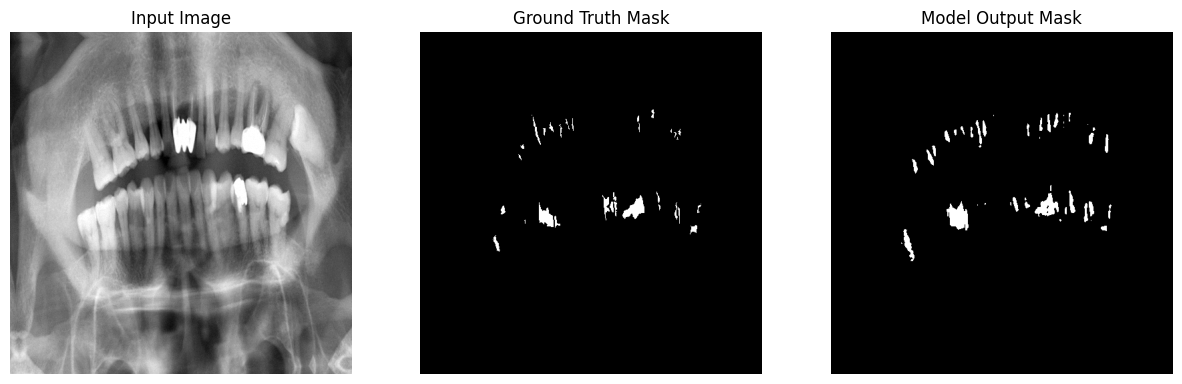

Test Loss (G): 0.2789 | Dice Score: 0.4677
Dice score is 0.024313222616910934


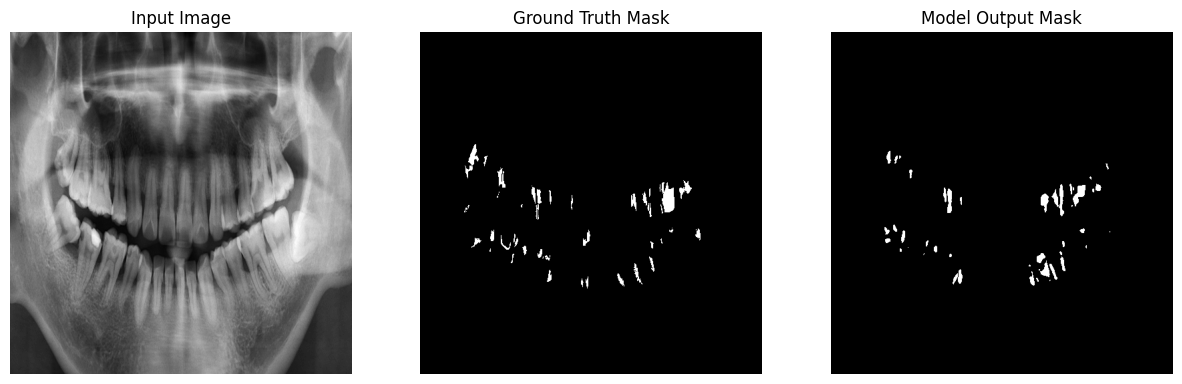

Epoch 32/400
----------


Train Loss (G): 0.2849 | Dice Score: 0.4546


Test Loss (G): 0.2676 | Dice Score: 0.4865
Best model saved with Dice score: 0.4865
Epoch 33/400
----------


Train Loss (G): 0.2802 | Dice Score: 0.4623


Test Loss (G): 0.2876 | Dice Score: 0.4558
Epoch 34/400
----------


Train Loss (G): 0.2824 | Dice Score: 0.4588


Test Loss (G): 0.2763 | Dice Score: 0.4747
Epoch 35/400
----------


Train Loss (G): 0.2764 | Dice Score: 0.4690


Test Loss (G): 0.2813 | Dice Score: 0.4590
Epoch 36/400
----------


Train Loss (G): 0.2770 | Dice Score: 0.4678


Test Loss (G): 0.3251 | Dice Score: 0.3756
Epoch 37/400
----------


Train Loss (G): 0.2775 | Dice Score: 0.4668


Test Loss (G): 0.2875 | Dice Score: 0.4403
Epoch 38/400
----------


Train Loss (G): 0.2758 | Dice Score: 0.4705


Test Loss (G): 0.2651 | Dice Score: 0.4938
Best model saved with Dice score: 0.4938
Epoch 39/400
----------


Train Loss (G): 0.2861 | Dice Score: 0.4500


Test Loss (G): 0.2681 | Dice Score: 0.4911
Epoch 40/400
----------


Train Loss (G): 0.2719 | Dice Score: 0.4770


Test Loss (G): 0.2675 | Dice Score: 0.4861
Epoch 41/400
----------


Train Loss (G): 0.2714 | Dice Score: 0.4788
Dice score is 0.013609153218567371


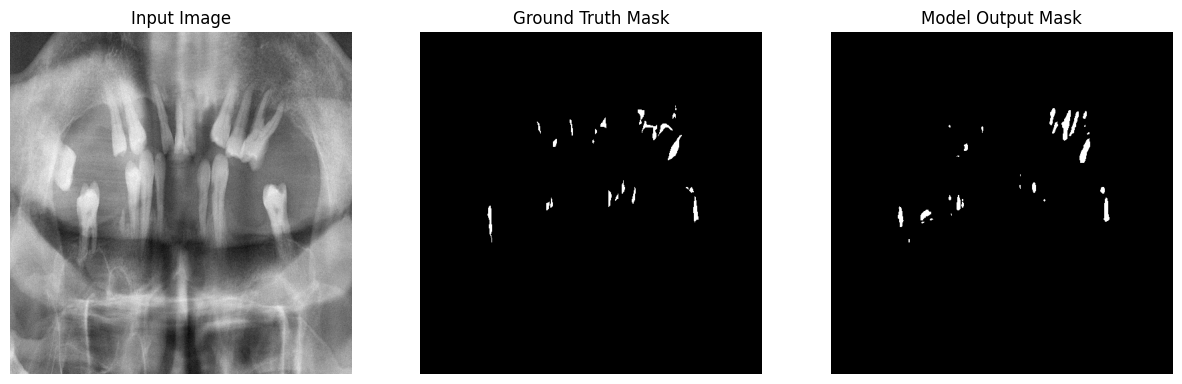

Test Loss (G): 0.2671 | Dice Score: 0.4881
Dice score is 0.024316979572176933


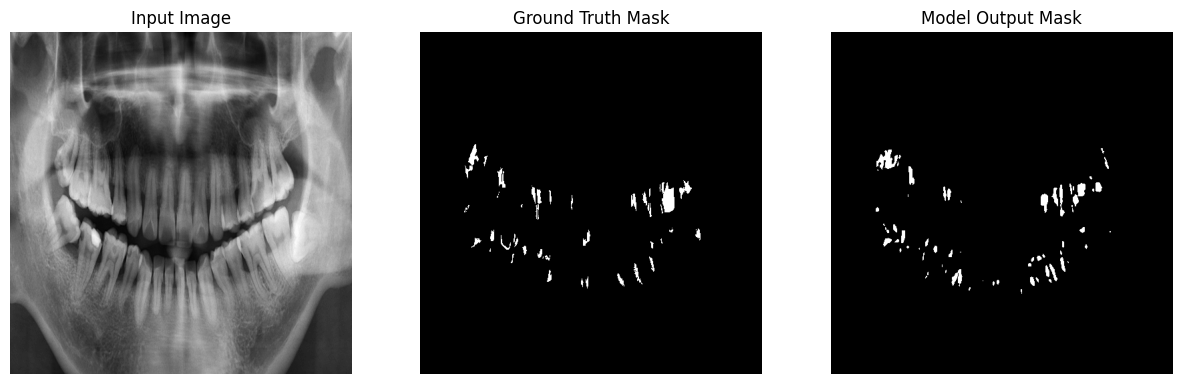

Epoch 42/400
----------


Train Loss (G): 0.2686 | Dice Score: 0.4832


Test Loss (G): 0.2673 | Dice Score: 0.4952
Best model saved with Dice score: 0.4952
Epoch 43/400
----------


Train Loss (G): 0.2656 | Dice Score: 0.4888


Test Loss (G): 0.2668 | Dice Score: 0.4863
Epoch 44/400
----------


Train Loss (G): 0.2676 | Dice Score: 0.4854


Test Loss (G): 0.2742 | Dice Score: 0.4752
Epoch 45/400
----------


Train Loss (G): 0.2659 | Dice Score: 0.4892


Test Loss (G): 0.2818 | Dice Score: 0.4624
Epoch 46/400
----------


Train Loss (G): 0.2678 | Dice Score: 0.4854


Test Loss (G): 0.2657 | Dice Score: 0.4882
Epoch 47/400
----------


Train Loss (G): 0.2630 | Dice Score: 0.4934


Test Loss (G): 0.2727 | Dice Score: 0.4776
Epoch 48/400
----------


Train Loss (G): 0.2636 | Dice Score: 0.4926


Test Loss (G): 0.2571 | Dice Score: 0.5042
Best model saved with Dice score: 0.5042
Epoch 49/400
----------


Train Loss (G): 0.2618 | Dice Score: 0.4951


Train Loss (G): 0.2524 | Dice Score: 0.5139
Dice score is 0.02304675802588463


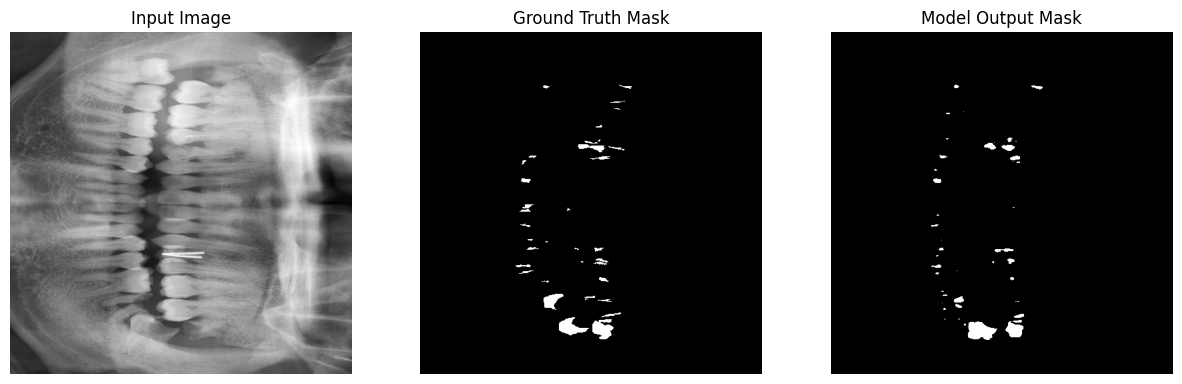

Test Loss (G): 0.2528 | Dice Score: 0.5151
Best model saved with Dice score: 0.5151
Dice score is 0.024313222616910934


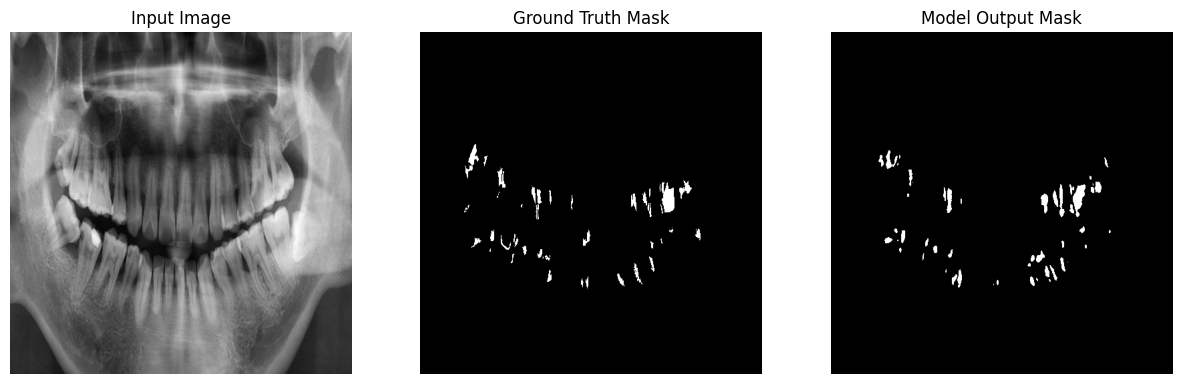

Epoch 52/400
----------


Train Loss (G): 0.2467 | Dice Score: 0.5241


Test Loss (G): 0.2545 | Dice Score: 0.5099
Epoch 53/400
----------


Train Loss (G): 0.2466 | Dice Score: 0.5241


Test Loss (G): 0.2526 | Dice Score: 0.5148
Epoch 54/400
----------


Train Loss (G): 0.2474 | Dice Score: 0.5227


Test Loss (G): 0.2528 | Dice Score: 0.5146
Epoch 55/400
----------


Train Loss (G): 0.2478 | Dice Score: 0.5222


Test Loss (G): 0.2571 | Dice Score: 0.5008
Epoch 56/400
----------


Train Loss (G): 0.2471 | Dice Score: 0.5234


Test Loss (G): 0.2475 | Dice Score: 0.5225
Best model saved with Dice score: 0.5225
Epoch 57/400
----------


Train Loss (G): 0.2444 | Dice Score: 0.5287


Test Loss (G): 0.2510 | Dice Score: 0.5152
Epoch 58/400
----------


Train Loss (G): 0.2428 | Dice Score: 0.5310


Test Loss (G): 0.2456 | Dice Score: 0.5282
Best model saved with Dice score: 0.5282
Epoch 59/400
----------


Train Loss (G): 0.2419 | Dice Score: 0.5335


Test Loss (G): 0.2487 | Dice Score: 0.5190
Epoch 60/400
----------


Train Loss (G): 0.2412 | Dice Score: 0.5348


Test Loss (G): 0.2628 | Dice Score: 0.4889
Epoch 61/400
----------


Train Loss (G): 0.2450 | Dice Score: 0.5270
Dice score is 0.007282346952706575


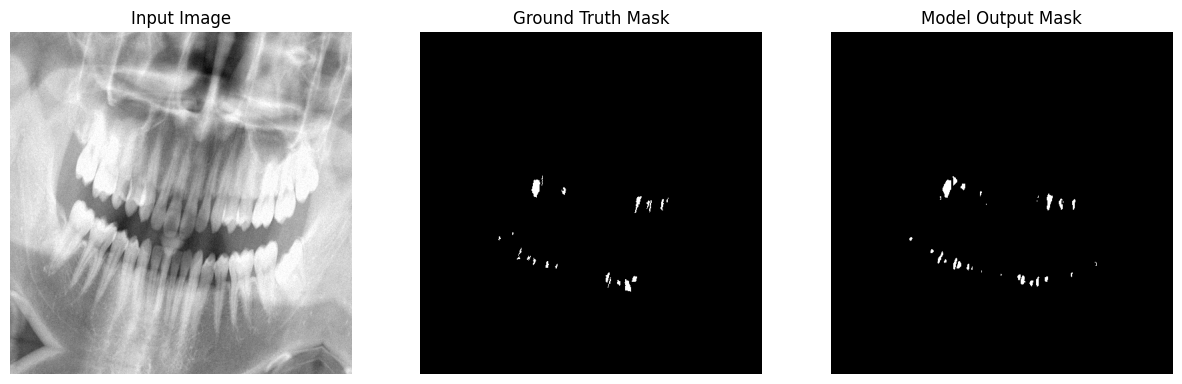

Test Loss (G): 0.2459 | Dice Score: 0.5245
Dice score is 0.024313222616910934


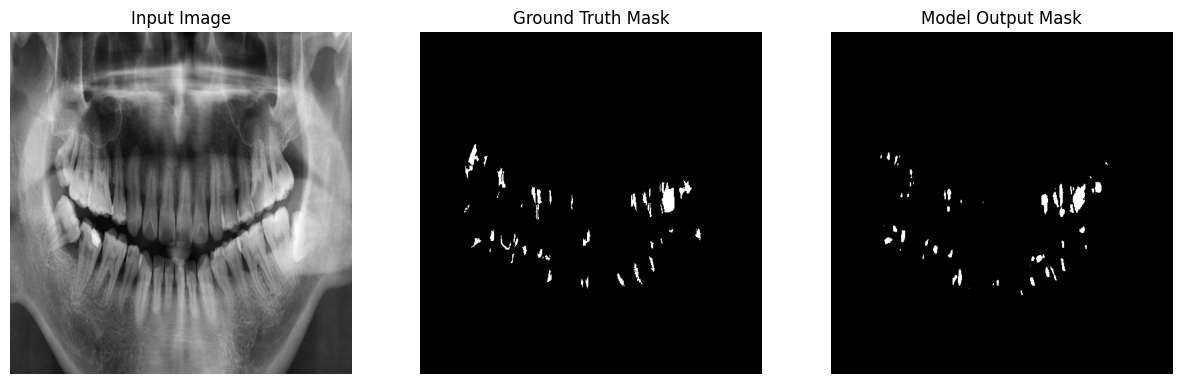

Epoch 62/400
----------


Train Loss (G): 0.2421 | Dice Score: 0.5315


Test Loss (G): 0.2492 | Dice Score: 0.5204
Epoch 63/400
----------


Train Loss (G): 0.2410 | Dice Score: 0.5356


Test Loss (G): 0.2473 | Dice Score: 0.5214
Epoch 64/400
----------


Train Loss (G): 0.2397 | Dice Score: 0.5373


Test Loss (G): 0.2507 | Dice Score: 0.5182
Epoch 65/400
----------


Train Loss (G): 0.2408 | Dice Score: 0.5360


Test Loss (G): 0.2436 | Dice Score: 0.5297
Best model saved with Dice score: 0.5297
Epoch 66/400
----------


Train Loss (G): 0.2381 | Dice Score: 0.5406


Test Loss (G): 0.2435 | Dice Score: 0.5305
Best model saved with Dice score: 0.5305
Epoch 67/400
----------


Train Loss (G): 0.2424 | Dice Score: 0.5323


Test Loss (G): 0.2463 | Dice Score: 0.5261
Epoch 68/400
----------


Train Loss (G): 0.2398 | Dice Score: 0.5364


Test Loss (G): 0.2584 | Dice Score: 0.5087
Epoch 69/400
----------


Train Loss (G): 0.2395 | Dice Score: 0.5373


Test Loss (G): 0.2447 | Dice Score: 0.5306
Best model saved with Dice score: 0.5306
Epoch 70/400
----------


Train Loss (G): 0.2385 | Dice Score: 0.5397


Test Loss (G): 0.2438 | Dice Score: 0.5287
Epoch 71/400
----------


Train Loss (G): 0.2360 | Dice Score: 0.5452
Dice score is 0.007630686741322279


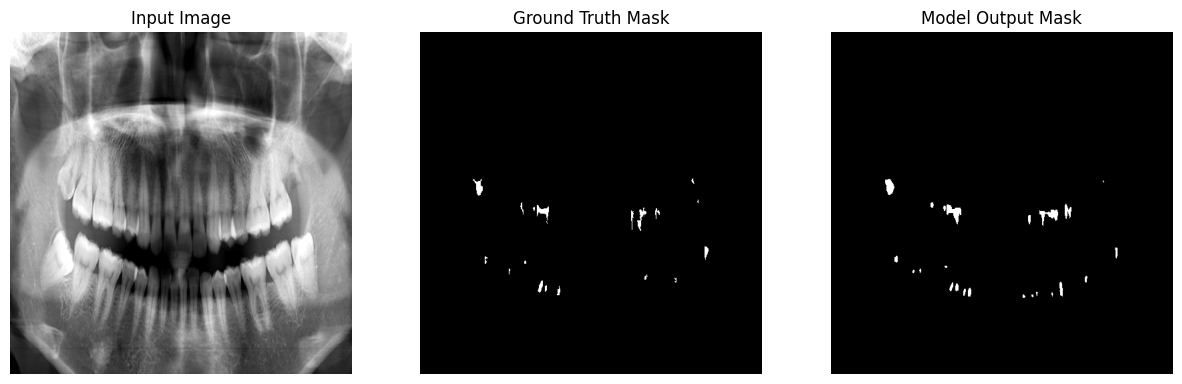

Test Loss (G): 0.2454 | Dice Score: 0.5249
Dice score is 0.024313222616910934


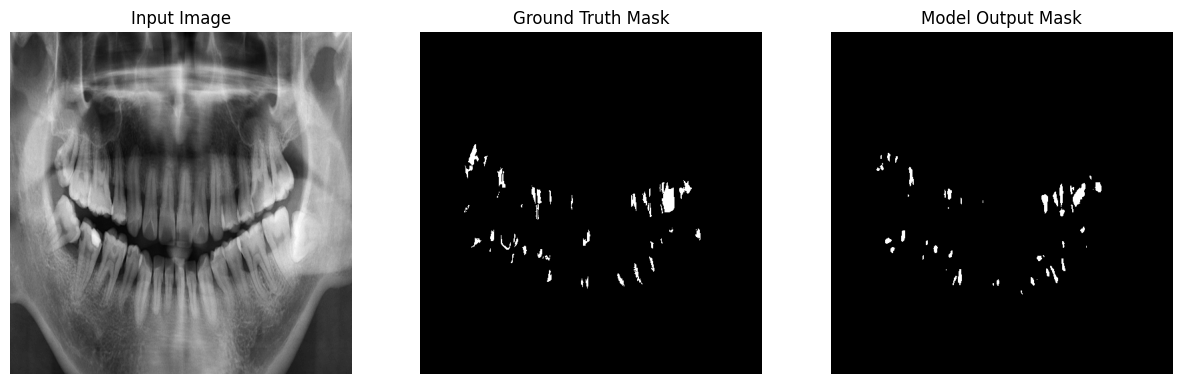

Epoch 72/400
----------


Train Loss (G): 0.2380 | Dice Score: 0.5408


Test Loss (G): 0.2384 | Dice Score: 0.5413
Best model saved with Dice score: 0.5413
Epoch 73/400
----------


Train Loss (G): 0.2334 | Dice Score: 0.5488


Test Loss (G): 0.2371 | Dice Score: 0.5427
Best model saved with Dice score: 0.5427
Epoch 74/400
----------


Train Loss (G): 0.2358 | Dice Score: 0.5438


Test Loss (G): 0.2496 | Dice Score: 0.5190
Epoch 75/400
----------


Train Loss (G): 0.2340 | Dice Score: 0.5472


Test Loss (G): 0.2445 | Dice Score: 0.5298
Epoch 76/400
----------


Train Loss (G): 0.2341 | Dice Score: 0.5476


Test Loss (G): 0.2411 | Dice Score: 0.5345
Epoch 77/400
----------


Train Loss (G): 0.2374 | Dice Score: 0.5411


Test Loss (G): 0.2496 | Dice Score: 0.5162
Epoch 78/400
----------


Train Loss (G): 0.2344 | Dice Score: 0.5482


Test Loss (G): 0.2404 | Dice Score: 0.5361
Epoch 79/400
----------


Train Loss (G): 0.2335 | Dice Score: 0.5478


Test Loss (G): 0.2687 | Dice Score: 0.4867
Epoch 80/400
----------


Train Loss (G): 0.2368 | Dice Score: 0.5429


Test Loss (G): 0.2422 | Dice Score: 0.5324
Epoch 81/400
----------


Train Loss (G): 0.2333 | Dice Score: 0.5487
Dice score is 0.01188422180712223


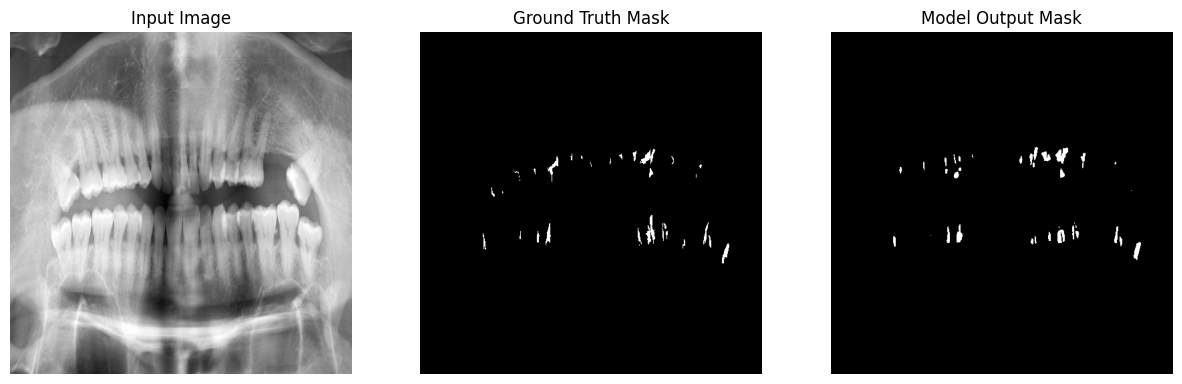

Test Loss (G): 0.2468 | Dice Score: 0.5225
Dice score is 0.024313222616910934


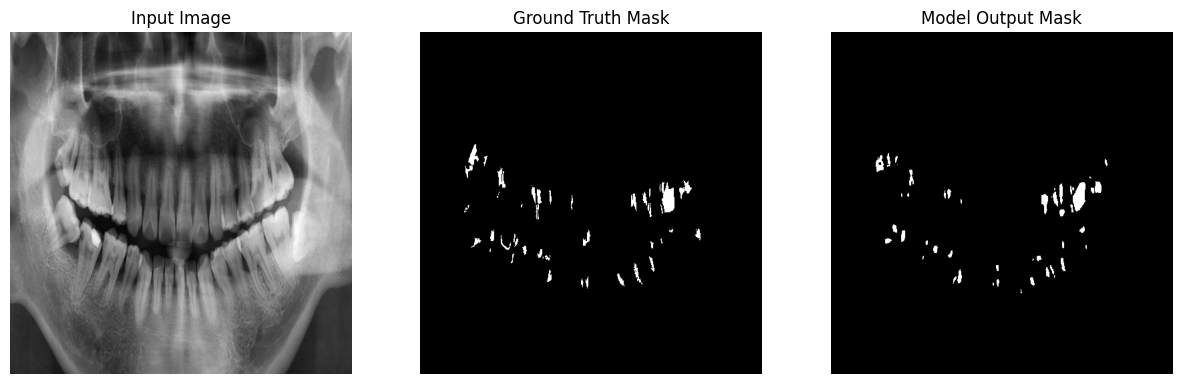

Epoch 82/400
----------


Train Loss (G): 0.2337 | Dice Score: 0.5488


Test Loss (G): 0.2427 | Dice Score: 0.5310
Epoch 83/400
----------


Train Loss (G): 0.2306 | Dice Score: 0.5540


Test Loss (G): 0.2491 | Dice Score: 0.5192
Epoch 84/400
----------


Train Loss (G): 0.2337 | Dice Score: 0.5486


Test Loss (G): 0.2373 | Dice Score: 0.5431
Best model saved with Dice score: 0.5431
Epoch 85/400
----------


Train Loss (G): 0.2328 | Dice Score: 0.5508


Test Loss (G): 0.2409 | Dice Score: 0.5342
Epoch 86/400
----------


Train Loss (G): 0.2300 | Dice Score: 0.5559


Test Loss (G): 0.2487 | Dice Score: 0.5175
Epoch 87/400
----------


Train Loss (G): 0.2297 | Dice Score: 0.5562


Test Loss (G): 0.2560 | Dice Score: 0.5045
Epoch 88/400
----------


Train Loss (G): 0.2320 | Dice Score: 0.5523


Test Loss (G): 0.2409 | Dice Score: 0.5347
Epoch 89/400
----------


Train Loss (G): 0.2291 | Dice Score: 0.5577


Test Loss (G): 0.2381 | Dice Score: 0.5392
Epoch 90/400
----------


Train Loss (G): 0.2292 | Dice Score: 0.5575


Test Loss (G): 0.2395 | Dice Score: 0.5366
Epoch 91/400
----------


Train Loss (G): 0.2304 | Dice Score: 0.5539
Dice score is 0.020023036748170853


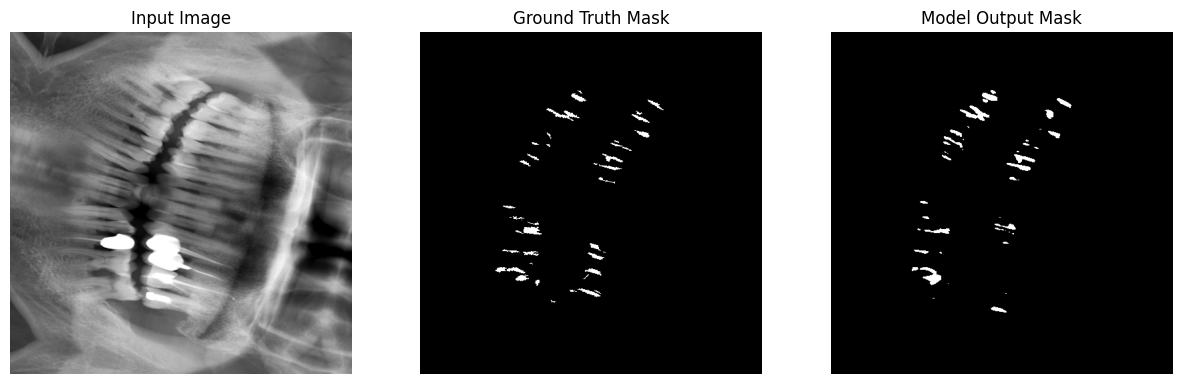

Test Loss (G): 0.2380 | Dice Score: 0.5407
Dice score is 0.024313222616910934


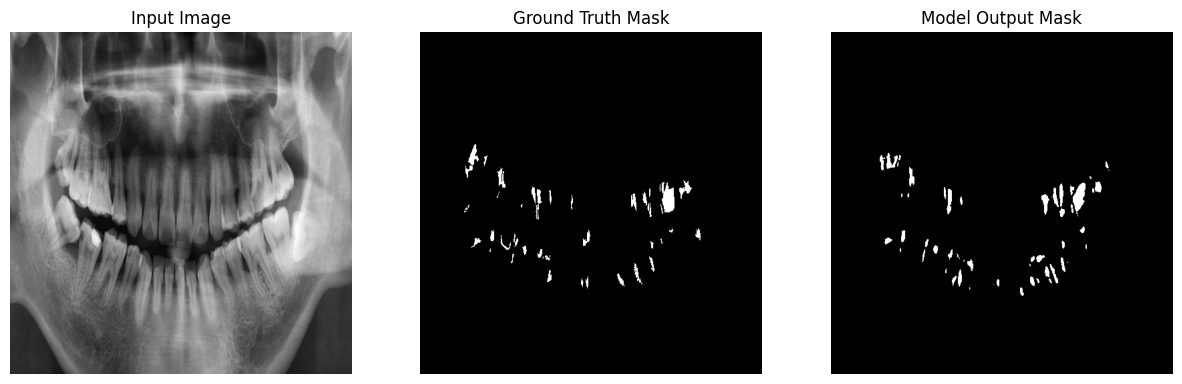

Epoch 92/400
----------


Train Loss (G): 0.2306 | Dice Score: 0.5550


Test Loss (G): 0.2362 | Dice Score: 0.5434
Best model saved with Dice score: 0.5434
Epoch 93/400
----------


Train Loss (G): 0.2312 | Dice Score: 0.5535


Test Loss (G): 0.2386 | Dice Score: 0.5394
Epoch 94/400
----------


Train Loss (G): 0.2290 | Dice Score: 0.5576


Test Loss (G): 0.2470 | Dice Score: 0.5213
Epoch 95/400
----------


Train Loss (G): 0.2247 | Dice Score: 0.5658


Test Loss (G): 0.2550 | Dice Score: 0.5103
Epoch 96/400
----------


Train Loss (G): 0.2282 | Dice Score: 0.5587


Test Loss (G): 0.2449 | Dice Score: 0.5285
Epoch 97/400
----------


Train Loss (G): 0.2302 | Dice Score: 0.5549


Test Loss (G): 0.2383 | Dice Score: 0.5400
Epoch 98/400
----------


Train Loss (G): 0.2289 | Dice Score: 0.5579


Test Loss (G): 0.2540 | Dice Score: 0.5087
Epoch 99/400
----------


Train Loss (G): 0.2291 | Dice Score: 0.5577


Test Loss (G): 0.2461 | Dice Score: 0.5242
Epoch 100/400
----------


Train Loss (G): 0.2263 | Dice Score: 0.5623


Test Loss (G): 0.2467 | Dice Score: 0.5208
Epoch 101/400
----------


Train Loss (G): 0.2227 | Dice Score: 0.5689
Dice score is 0.001037059584632516


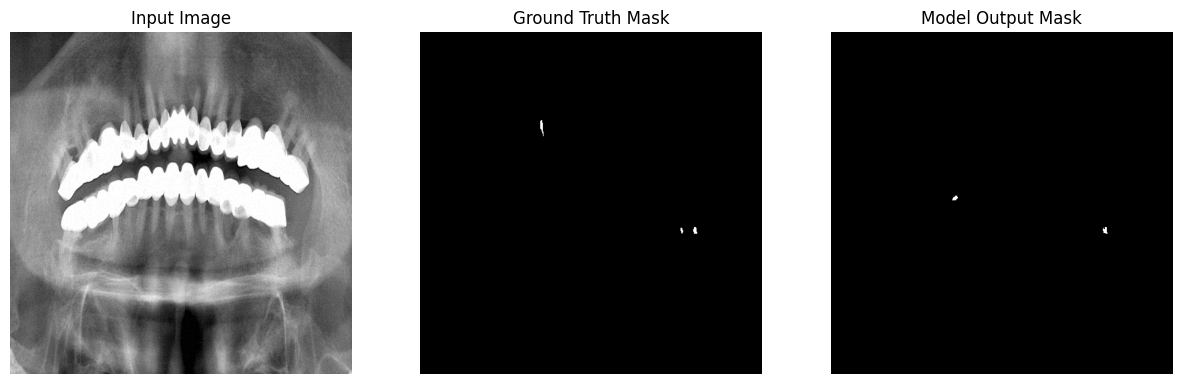

Test Loss (G): 0.2406 | Dice Score: 0.5340
Dice score is 0.024313222616910934


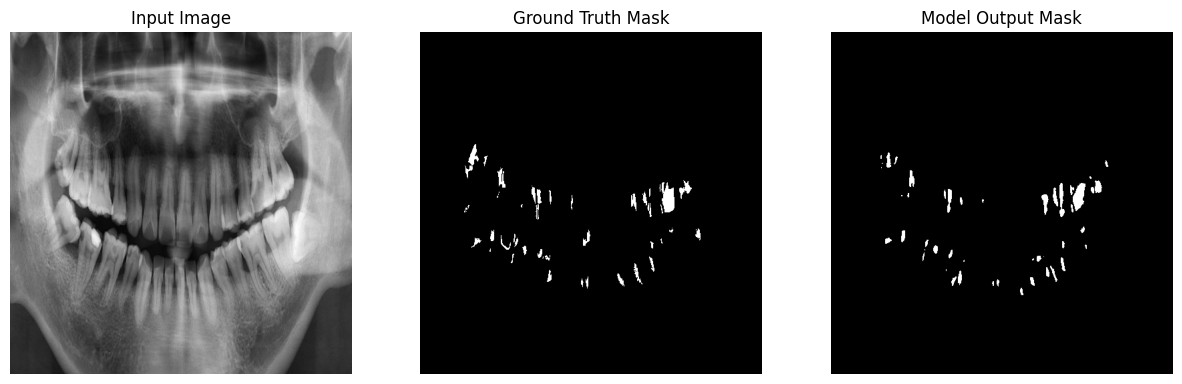

Epoch 102/400
----------


Train Loss (G): 0.2234 | Dice Score: 0.5681


Test Loss (G): 0.2438 | Dice Score: 0.5277
Epoch 103/400
----------


Train Loss (G): 0.2209 | Dice Score: 0.5733


Test Loss (G): 0.2433 | Dice Score: 0.5285
Epoch 104/400
----------


Train Loss (G): 0.2199 | Dice Score: 0.5752


Test Loss (G): 0.2388 | Dice Score: 0.5388
Epoch 105/400
----------


Train Loss (G): 0.2216 | Dice Score: 0.5717


Test Loss (G): 0.2389 | Dice Score: 0.5381
Epoch 106/400
----------


Train Loss (G): 0.2197 | Dice Score: 0.5753


Test Loss (G): 0.2373 | Dice Score: 0.5414
Epoch 107/400
----------


Train Loss (G): 0.2206 | Dice Score: 0.5745


Test Loss (G): 0.2392 | Dice Score: 0.5372
Epoch 108/400
----------


Train Loss (G): 0.2193 | Dice Score: 0.5763


Test Loss (G): 0.2343 | Dice Score: 0.5468
Best model saved with Dice score: 0.5468
Epoch 109/400
----------


Train Loss (G): 0.2185 | Dice Score: 0.5772


Test Loss (G): 0.2361 | Dice Score: 0.5434
Epoch 110/400
----------


Train Loss (G): 0.2174 | Dice Score: 0.5797


Test Loss (G): 0.2412 | Dice Score: 0.5336
Epoch 111/400
----------


Train Loss (G): 0.2210 | Dice Score: 0.5727
Dice score is 0.018091987818479538


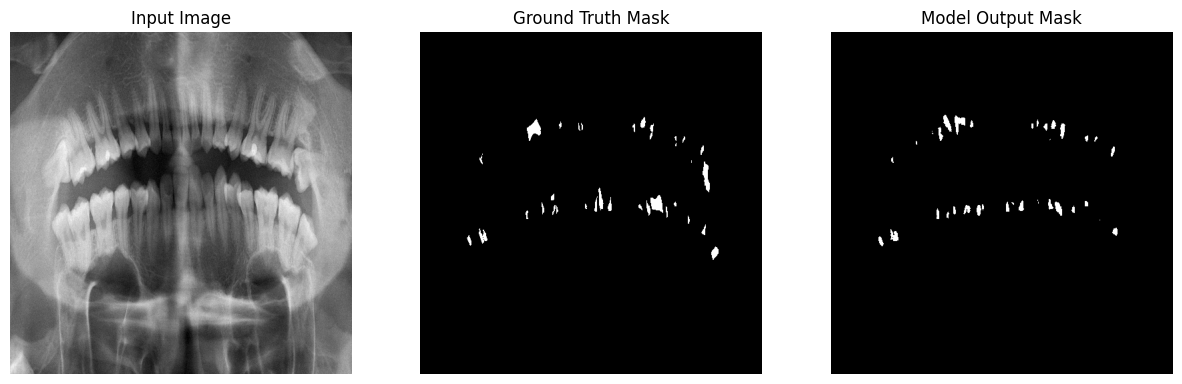

Test Loss (G): 0.2435 | Dice Score: 0.5281
Dice score is 0.024313222616910934


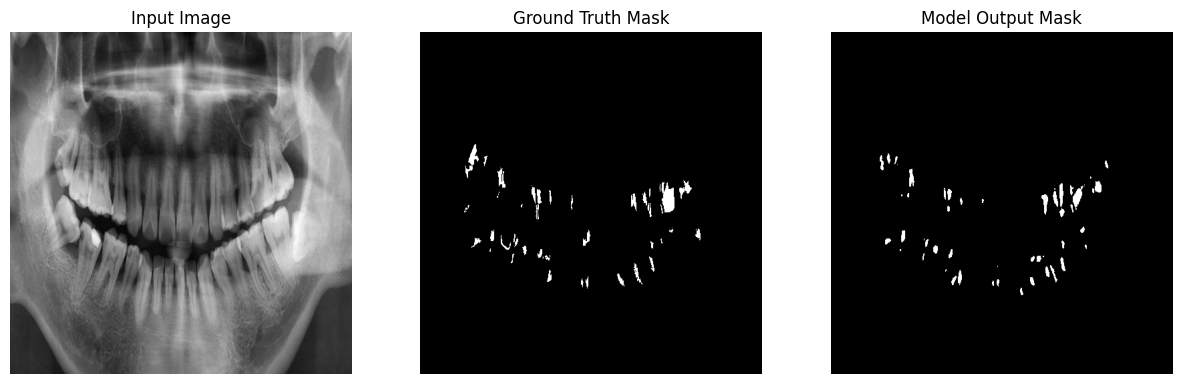

Epoch 112/400
----------


Train Loss (G): 0.2201 | Dice Score: 0.5748


Test Loss (G): 0.2357 | Dice Score: 0.5441
Epoch 113/400
----------


Train Loss (G): 0.2188 | Dice Score: 0.5772


Test Loss (G): 0.2454 | Dice Score: 0.5241
Epoch 114/400
----------


Train Loss (G): 0.2175 | Dice Score: 0.5792


Test Loss (G): 0.2384 | Dice Score: 0.5380
Epoch 115/400
----------


Train Loss (G): 0.2174 | Dice Score: 0.5804


Test Loss (G): 0.2435 | Dice Score: 0.5276
Epoch 116/400
----------


Train Loss (G): 0.2161 | Dice Score: 0.5826


Test Loss (G): 0.2351 | Dice Score: 0.5448
Epoch 117/400
----------


Train Loss (G): 0.2148 | Dice Score: 0.5856


Test Loss (G): 0.2372 | Dice Score: 0.5408
Epoch 118/400
----------


Train Loss (G): 0.2146 | Dice Score: 0.5852


Test Loss (G): 0.2401 | Dice Score: 0.5344
Epoch 119/400
----------


Train Loss (G): 0.2180 | Dice Score: 0.5788


Test Loss (G): 0.2390 | Dice Score: 0.5371
Epoch 120/400
----------


Train Loss (G): 0.2156 | Dice Score: 0.5828


Test Loss (G): 0.2428 | Dice Score: 0.5307
Epoch 121/400
----------


Train Loss (G): 0.2149 | Dice Score: 0.5851
Dice score is 0.014368980191648006


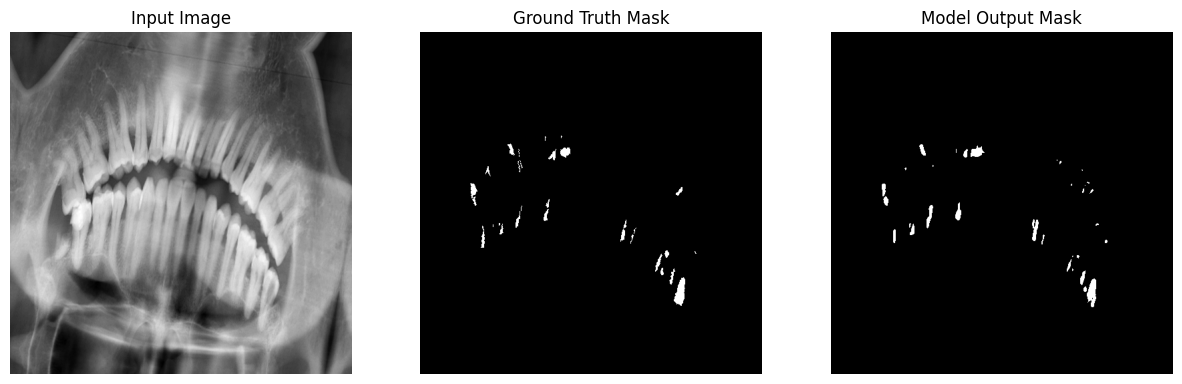

Test Loss (G): 0.2404 | Dice Score: 0.5341
Dice score is 0.024313222616910934


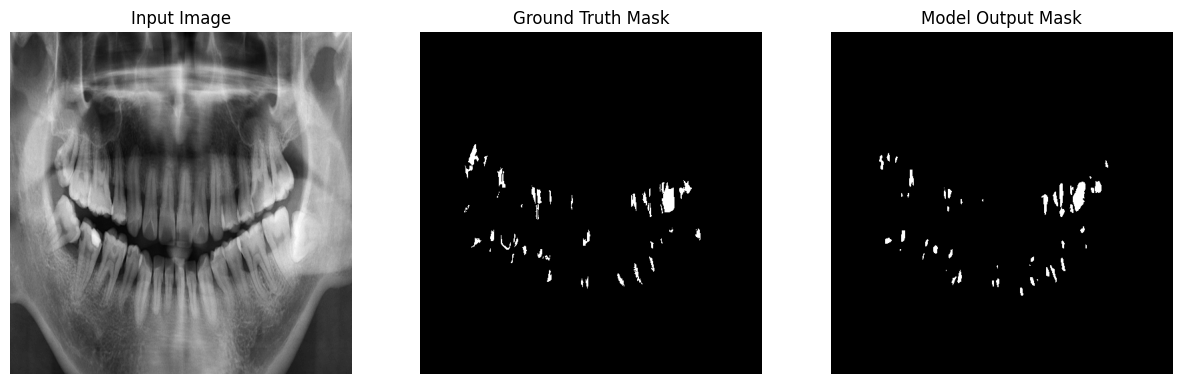

Epoch 122/400
----------


Train Loss (G): 0.2147 | Dice Score: 0.5857


Test Loss (G): 0.2415 | Dice Score: 0.5326
Epoch 123/400
----------


Train Loss (G): 0.2147 | Dice Score: 0.5854


Test Loss (G): 0.2387 | Dice Score: 0.5383
Epoch 124/400
----------


Train Loss (G): 0.2160 | Dice Score: 0.5818


Test Loss (G): 0.2359 | Dice Score: 0.5434
Epoch 125/400
----------


Train Loss (G): 0.2141 | Dice Score: 0.5869


Test Loss (G): 0.2340 | Dice Score: 0.5478
Best model saved with Dice score: 0.5478
Epoch 126/400
----------


Train Loss (G): 0.2157 | Dice Score: 0.5826


Test Loss (G): 0.2422 | Dice Score: 0.5304
Epoch 127/400
----------


Train Loss (G): 0.2139 | Dice Score: 0.5867


Test Loss (G): 0.2385 | Dice Score: 0.5381
Epoch 128/400
----------


Train Loss (G): 0.2129 | Dice Score: 0.5889


Test Loss (G): 0.2377 | Dice Score: 0.5407
Epoch 129/400
----------


Train Loss (G): 0.2148 | Dice Score: 0.5854


Test Loss (G): 0.2341 | Dice Score: 0.5468
Epoch 130/400
----------


Train Loss (G): 0.2146 | Dice Score: 0.5848


Test Loss (G): 0.2393 | Dice Score: 0.5369
Epoch 131/400
----------


Train Loss (G): 0.2130 | Dice Score: 0.5881
Dice score is 0.02245767042040825


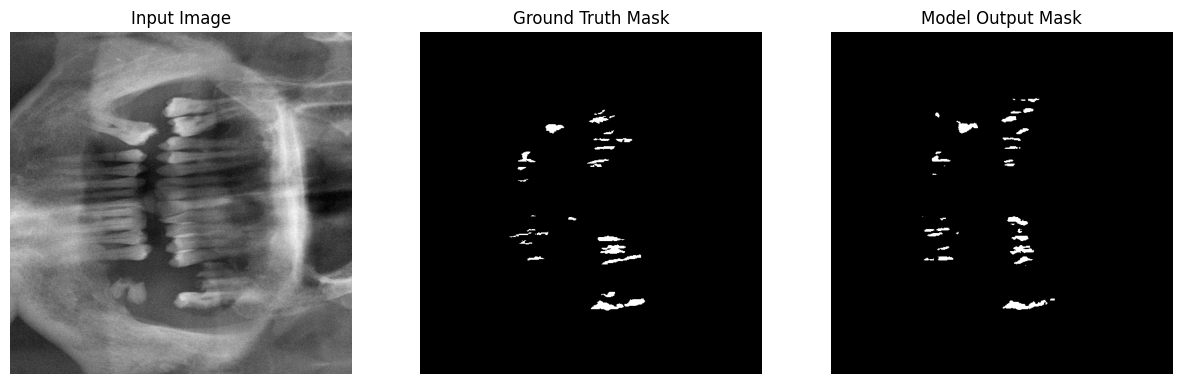

Test Loss (G): 0.2341 | Dice Score: 0.5472
Dice score is 0.024313222616910934


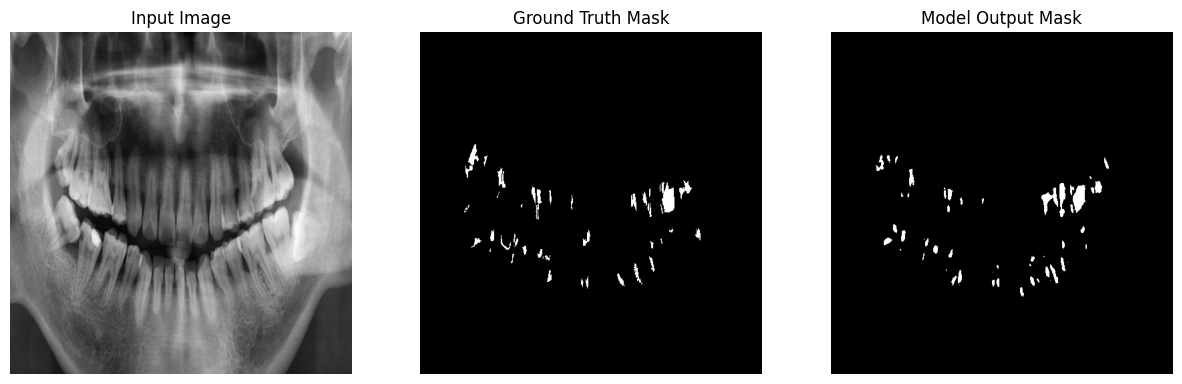

Epoch 132/400
----------


Train Loss (G): 0.2138 | Dice Score: 0.5856


Test Loss (G): 0.2377 | Dice Score: 0.5402
Epoch 133/400
----------


Train Loss (G): 0.2146 | Dice Score: 0.5840


Test Loss (G): 0.2413 | Dice Score: 0.5330
Epoch 134/400
----------


Train Loss (G): 0.2134 | Dice Score: 0.5866


Test Loss (G): 0.2352 | Dice Score: 0.5452
Epoch 135/400
----------


Train Loss (G): 0.2156 | Dice Score: 0.5832


Test Loss (G): 0.2356 | Dice Score: 0.5444
Epoch 136/400
----------


Train Loss (G): 0.2125 | Dice Score: 0.5893


Test Loss (G): 0.2406 | Dice Score: 0.5338
Epoch 137/400
----------


Train Loss (G): 0.2136 | Dice Score: 0.5877


Test Loss (G): 0.2414 | Dice Score: 0.5320
Epoch 138/400
----------


Train Loss (G): 0.2124 | Dice Score: 0.5897


Test Loss (G): 0.2399 | Dice Score: 0.5354
Epoch 139/400
----------


Train Loss (G): 0.2136 | Dice Score: 0.5879


Test Loss (G): 0.2446 | Dice Score: 0.5255
Epoch 140/400
----------


Train Loss (G): 0.2122 | Dice Score: 0.5898


Test Loss (G): 0.2372 | Dice Score: 0.5404
Epoch 141/400
----------


Train Loss (G): 0.2133 | Dice Score: 0.5874
Dice score is 0.012630302459001541


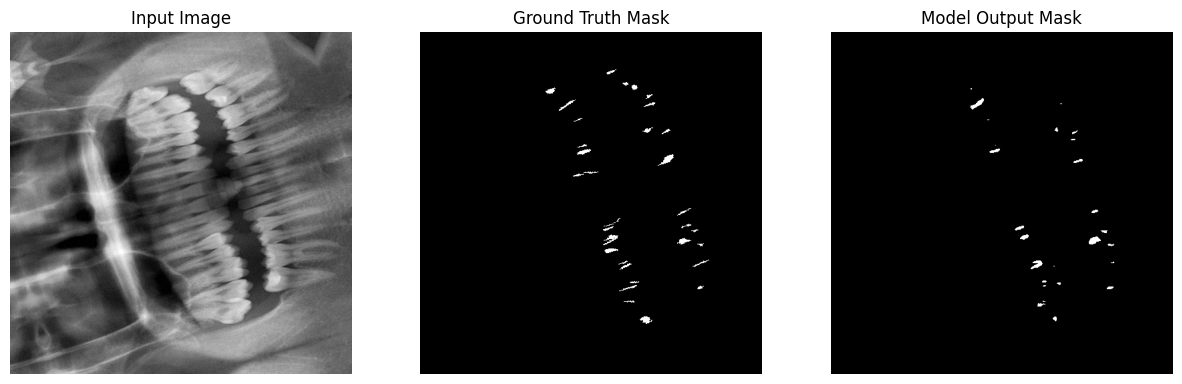

Test Loss (G): 0.2403 | Dice Score: 0.5361
Dice score is 0.024313222616910934


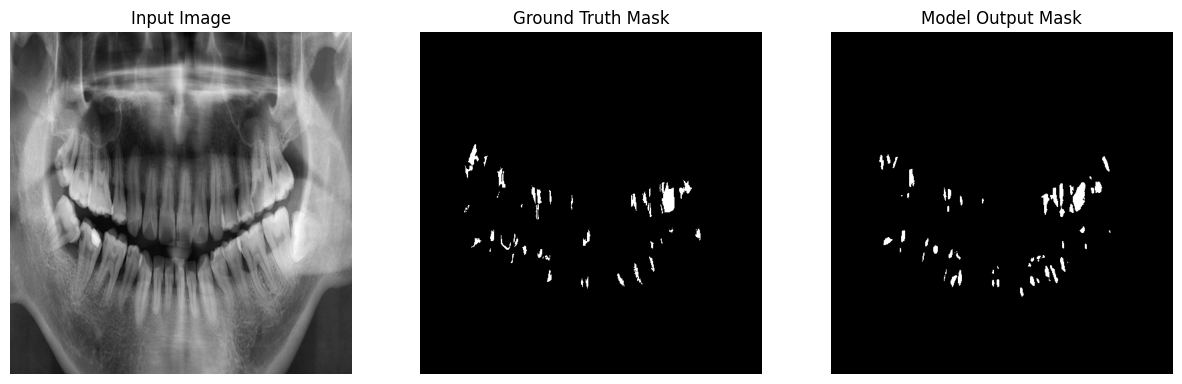

Epoch 142/400
----------


Train Loss (G): 0.2099 | Dice Score: 0.5942


Test Loss (G): 0.2375 | Dice Score: 0.5400
Epoch 143/400
----------


Train Loss (G): 0.2128 | Dice Score: 0.5887


Test Loss (G): 0.2378 | Dice Score: 0.5401
Epoch 144/400
----------


Train Loss (G): 0.2101 | Dice Score: 0.5940


Test Loss (G): 0.2412 | Dice Score: 0.5323
Epoch 145/400
----------


Train Loss (G): 0.2116 | Dice Score: 0.5911


Test Loss (G): 0.2360 | Dice Score: 0.5432
Epoch 146/400
----------


Train Loss (G): 0.2125 | Dice Score: 0.5890


Test Loss (G): 0.2395 | Dice Score: 0.5353
Epoch 147/400
----------


Train Loss (G): 0.2102 | Dice Score: 0.5930


Test Loss (G): 0.2338 | Dice Score: 0.5480
Best model saved with Dice score: 0.5480
Epoch 148/400
----------


Train Loss (G): 0.2107 | Dice Score: 0.5931


Test Loss (G): 0.2478 | Dice Score: 0.5190
Epoch 149/400
----------


Train Loss (G): 0.2120 | Dice Score: 0.5903


Test Loss (G): 0.2406 | Dice Score: 0.5353
Epoch 150/400
----------


Train Loss (G): 0.2110 | Dice Score: 0.5928


Test Loss (G): 0.2404 | Dice Score: 0.5332
Epoch 151/400
----------


Train Loss (G): 0.2083 | Dice Score: 0.5973
Dice score is 0.01232138741761446


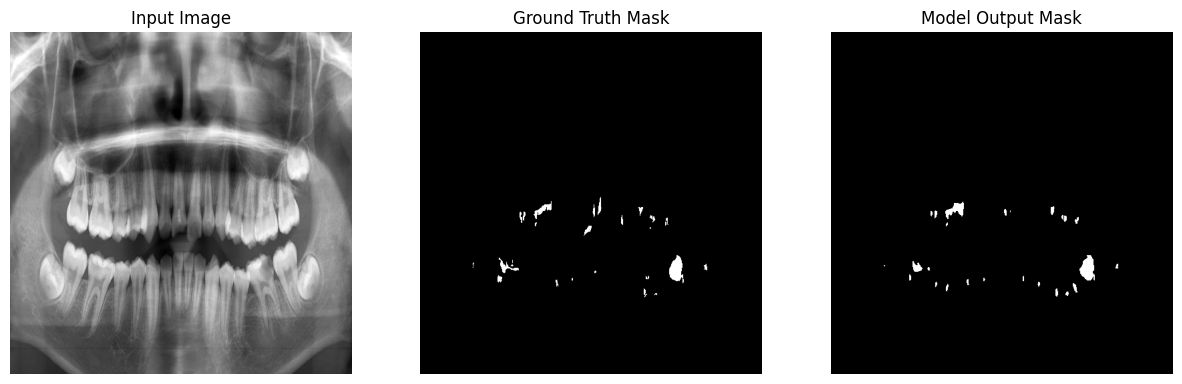

Test Loss (G): 0.2388 | Dice Score: 0.5366
Dice score is 0.024313222616910934


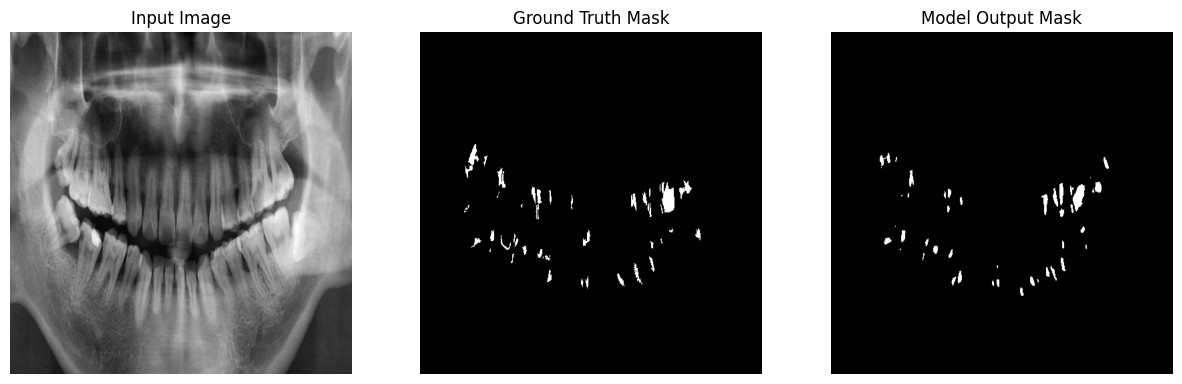

Epoch 152/400
----------


Train Loss (G): 0.2076 | Dice Score: 0.5986


Test Loss (G): 0.2367 | Dice Score: 0.5414
Epoch 153/400
----------


Train Loss (G): 0.2082 | Dice Score: 0.5972


Test Loss (G): 0.2358 | Dice Score: 0.5430
Epoch 154/400
----------


Train Loss (G): 0.2074 | Dice Score: 0.5989


Test Loss (G): 0.2356 | Dice Score: 0.5440
Epoch 155/400
----------


Train Loss (G): 0.2106 | Dice Score: 0.5921


Test Loss (G): 0.2364 | Dice Score: 0.5419
Epoch 156/400
----------


Train Loss (G): 0.2048 | Dice Score: 0.6045


Test Loss (G): 0.2368 | Dice Score: 0.5413
Epoch 157/400
----------


Train Loss (G): 0.2079 | Dice Score: 0.5977


Test Loss (G): 0.2369 | Dice Score: 0.5410
Epoch 158/400
----------


Train Loss (G): 0.2050 | Dice Score: 0.6035


Test Loss (G): 0.2382 | Dice Score: 0.5389
Epoch 159/400
----------


Train Loss (G): 0.2073 | Dice Score: 0.5987


Test Loss (G): 0.2386 | Dice Score: 0.5374
Epoch 160/400
----------


Train Loss (G): 0.2064 | Dice Score: 0.6012


Test Loss (G): 0.2346 | Dice Score: 0.5456
Epoch 161/400
----------


Train Loss (G): 0.2030 | Dice Score: 0.6073
Dice score is 0.015383683145046234


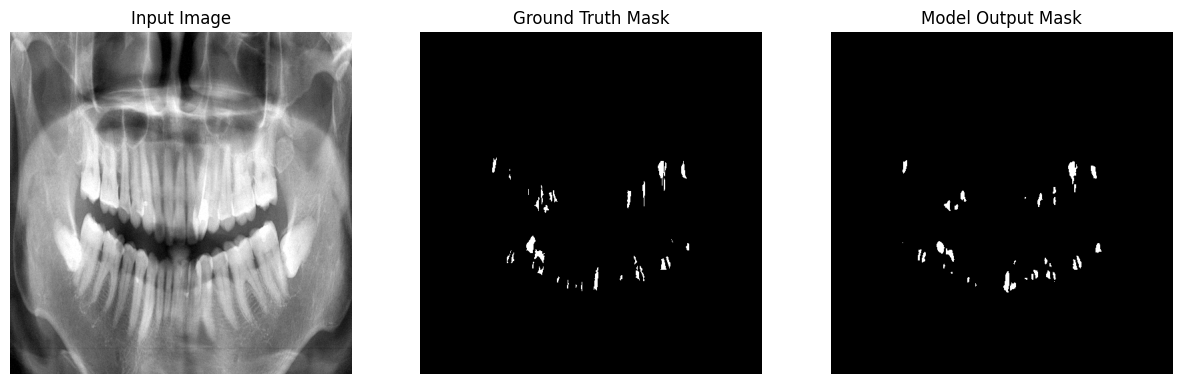

Test Loss (G): 0.2366 | Dice Score: 0.5411
Dice score is 0.024313222616910934


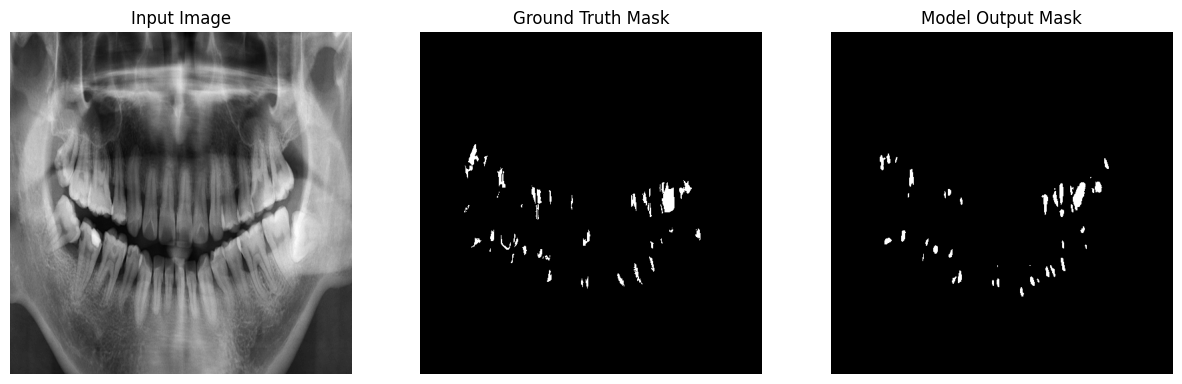

Epoch 162/400
----------


Train Loss (G): 0.2057 | Dice Score: 0.6027


Test Loss (G): 0.2396 | Dice Score: 0.5350
Epoch 163/400
----------


Train Loss (G): 0.2073 | Dice Score: 0.5992


Test Loss (G): 0.2351 | Dice Score: 0.5445
Epoch 164/400
----------


Train Loss (G): 0.2058 | Dice Score: 0.6019


Test Loss (G): 0.2389 | Dice Score: 0.5367
Epoch 165/400
----------


Train Loss (G): 0.2054 | Dice Score: 0.6029


Test Loss (G): 0.2331 | Dice Score: 0.5485
Best model saved with Dice score: 0.5485
Epoch 166/400
----------


Train Loss (G): 0.2067 | Dice Score: 0.6005


Test Loss (G): 0.2322 | Dice Score: 0.5503
Best model saved with Dice score: 0.5503
Epoch 167/400
----------


Train Loss (G): 0.2076 | Dice Score: 0.5983


Test Loss (G): 0.2359 | Dice Score: 0.5439
Epoch 168/400
----------


Train Loss (G): 0.2052 | Dice Score: 0.6032


Test Loss (G): 0.2359 | Dice Score: 0.5431
Epoch 169/400
----------


Train Loss (G): 0.2070 | Dice Score: 0.5996


Test Loss (G): 0.2355 | Dice Score: 0.5440
Epoch 170/400
----------


Train Loss (G): 0.2026 | Dice Score: 0.6076


Test Loss (G): 0.2373 | Dice Score: 0.5406
Epoch 171/400
----------


Train Loss (G): 0.2055 | Dice Score: 0.6030
Dice score is 0.03965645655989647


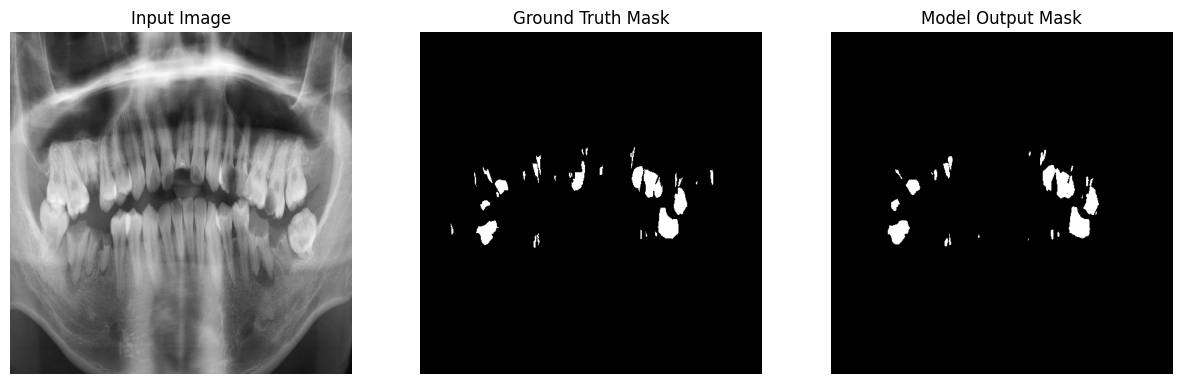

Test Loss (G): 0.2346 | Dice Score: 0.5454
Dice score is 0.024313222616910934


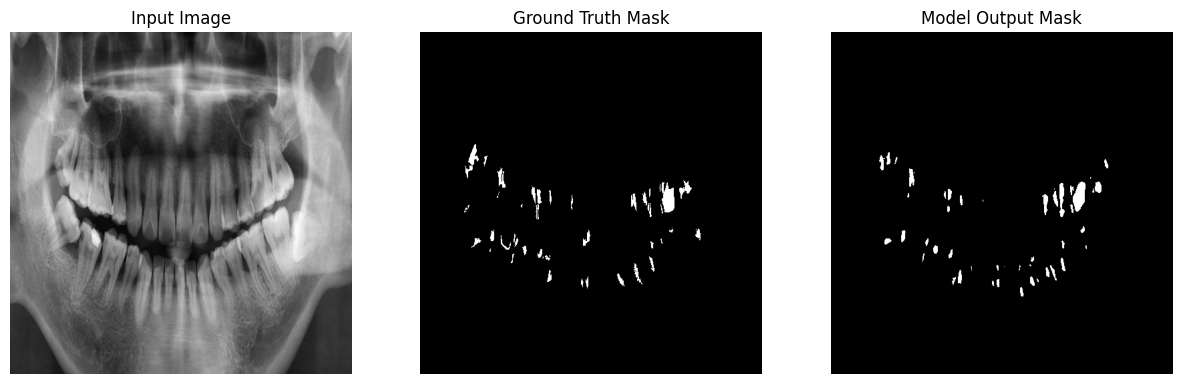

Epoch 172/400
----------


Train Loss (G): 0.2060 | Dice Score: 0.6020


Test Loss (G): 0.2370 | Dice Score: 0.5414
Epoch 173/400
----------


Train Loss (G): 0.2045 | Dice Score: 0.6042


Test Loss (G): 0.2338 | Dice Score: 0.5479
Epoch 174/400
----------


Train Loss (G): 0.2024 | Dice Score: 0.6087


Test Loss (G): 0.2390 | Dice Score: 0.5365
Epoch 175/400
----------


Train Loss (G): 0.2036 | Dice Score: 0.6062


Test Loss (G): 0.2328 | Dice Score: 0.5496
Epoch 176/400
----------


Train Loss (G): 0.2033 | Dice Score: 0.6066


Test Loss (G): 0.2336 | Dice Score: 0.5483
Epoch 177/400
----------


Train Loss (G): 0.2076 | Dice Score: 0.5985


Test Loss (G): 0.2338 | Dice Score: 0.5475
Epoch 178/400
----------


Train Loss (G): 0.2032 | Dice Score: 0.6067


Test Loss (G): 0.2371 | Dice Score: 0.5404
Epoch 179/400
----------


Train Loss (G): 0.2056 | Dice Score: 0.6021


Test Loss (G): 0.2333 | Dice Score: 0.5485
Epoch 180/400
----------


Train Loss (G): 0.2030 | Dice Score: 0.6068


Test Loss (G): 0.2311 | Dice Score: 0.5535
Best model saved with Dice score: 0.5535
Epoch 181/400
----------


Train Loss (G): 0.2045 | Dice Score: 0.6042
Dice score is 0.01068479847162962


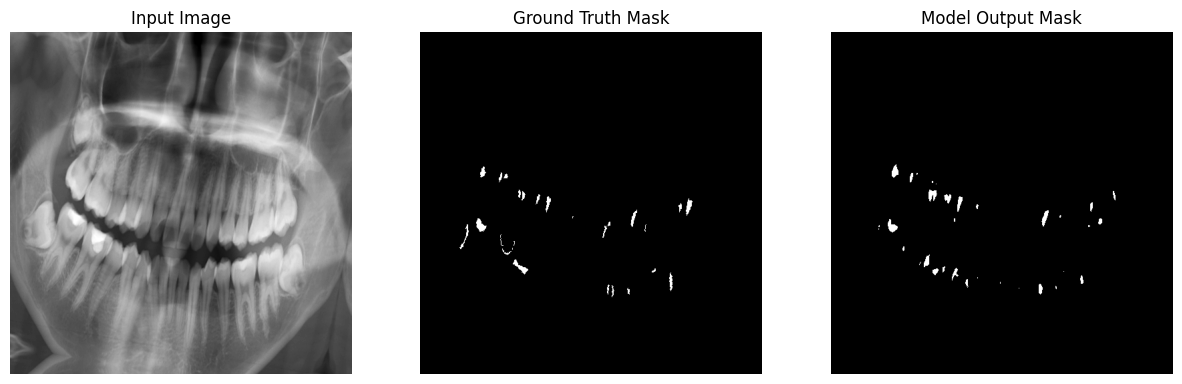

Test Loss (G): 0.2369 | Dice Score: 0.5416
Dice score is 0.024313222616910934


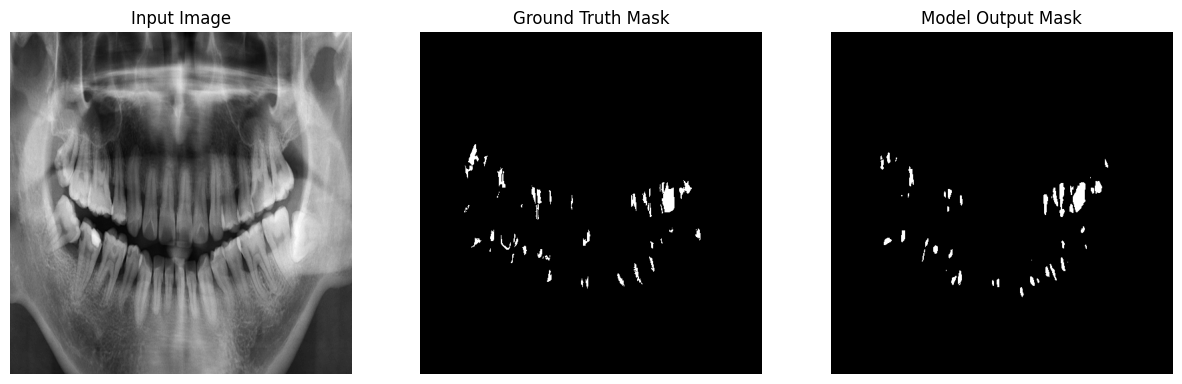

Epoch 182/400
----------


Train Loss (G): 0.2047 | Dice Score: 0.6038


Test Loss (G): 0.2381 | Dice Score: 0.5388
Epoch 183/400
----------


Train Loss (G): 0.2049 | Dice Score: 0.6043


Test Loss (G): 0.2389 | Dice Score: 0.5368
Epoch 184/400
----------


Train Loss (G): 0.2030 | Dice Score: 0.6073


Test Loss (G): 0.2381 | Dice Score: 0.5397
Epoch 185/400
----------


Train Loss (G): 0.2033 | Dice Score: 0.6074


Test Loss (G): 0.2365 | Dice Score: 0.5425
Epoch 186/400
----------


Train Loss (G): 0.2037 | Dice Score: 0.6057


Test Loss (G): 0.2325 | Dice Score: 0.5499
Epoch 187/400
----------


Train Loss (G): 0.2040 | Dice Score: 0.6053


Test Loss (G): 0.2397 | Dice Score: 0.5357
Epoch 188/400
----------


Train Loss (G): 0.2034 | Dice Score: 0.6068


Test Loss (G): 0.2362 | Dice Score: 0.5424
Epoch 189/400
----------


Train Loss (G): 0.2014 | Dice Score: 0.6114


Test Loss (G): 0.2390 | Dice Score: 0.5364
Epoch 190/400
----------


Train Loss (G): 0.2033 | Dice Score: 0.6068


Test Loss (G): 0.2361 | Dice Score: 0.5425
Epoch 191/400
----------


Train Loss (G): 0.2029 | Dice Score: 0.6076
Dice score is 0.01601453125476837


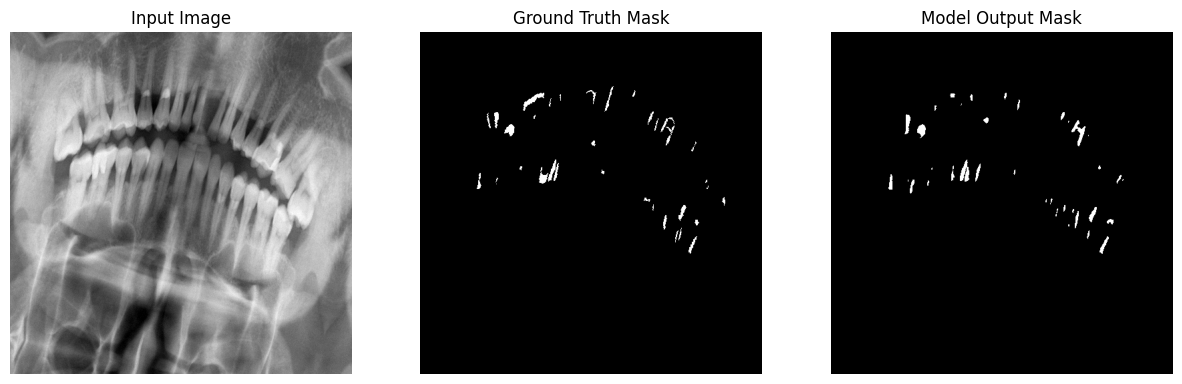

Test Loss (G): 0.2402 | Dice Score: 0.5340
Dice score is 0.024313222616910934


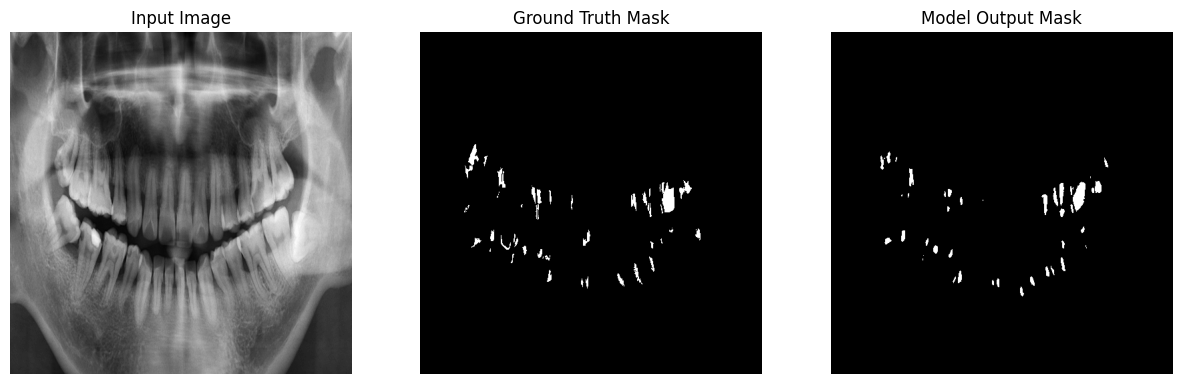

Epoch 192/400
----------


Train Loss (G): 0.2046 | Dice Score: 0.6044


Test Loss (G): 0.2358 | Dice Score: 0.5435
Epoch 193/400
----------


Train Loss (G): 0.2025 | Dice Score: 0.6086


Test Loss (G): 0.2393 | Dice Score: 0.5358
Epoch 194/400
----------


Train Loss (G): 0.2040 | Dice Score: 0.6053


Test Loss (G): 0.2393 | Dice Score: 0.5361
Epoch 195/400
----------


Train Loss (G): 0.2027 | Dice Score: 0.6082


Test Loss (G): 0.2355 | Dice Score: 0.5430
Epoch 196/400
----------


Train Loss (G): 0.2014 | Dice Score: 0.6104


Test Loss (G): 0.2404 | Dice Score: 0.5341
Epoch 197/400
----------


Train Loss (G): 0.2011 | Dice Score: 0.6112


Test Loss (G): 0.2344 | Dice Score: 0.5460
Epoch 198/400
----------


Train Loss (G): 0.2031 | Dice Score: 0.6077


Test Loss (G): 0.2383 | Dice Score: 0.5375
Epoch 199/400
----------


Train Loss (G): 0.2000 | Dice Score: 0.6135


Test Loss (G): 0.2361 | Dice Score: 0.5421
Epoch 200/400
----------


Train Loss (G): 0.2014 | Dice Score: 0.6106


Test Loss (G): 0.2377 | Dice Score: 0.5400
Epoch 201/400
----------


Train Loss (G): 0.2009 | Dice Score: 0.6118
Dice score is 0.018054526299238205


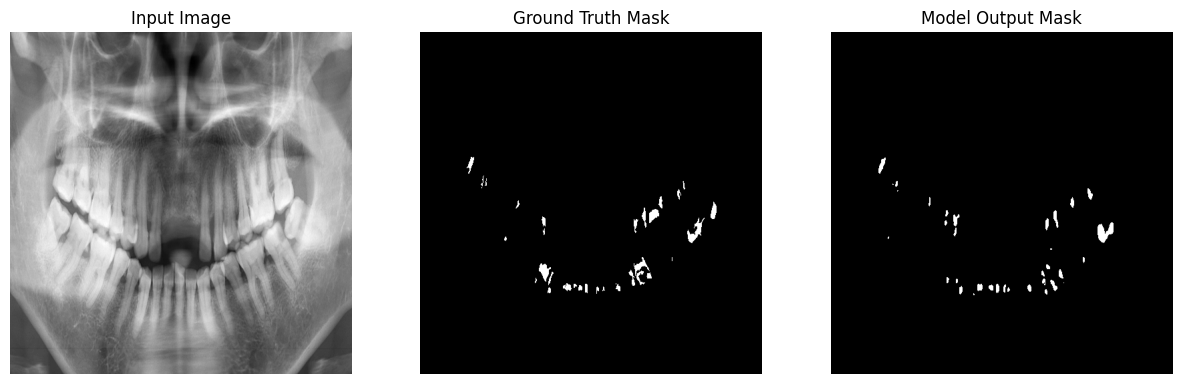

Test Loss (G): 0.2402 | Dice Score: 0.5339
Dice score is 0.024313222616910934


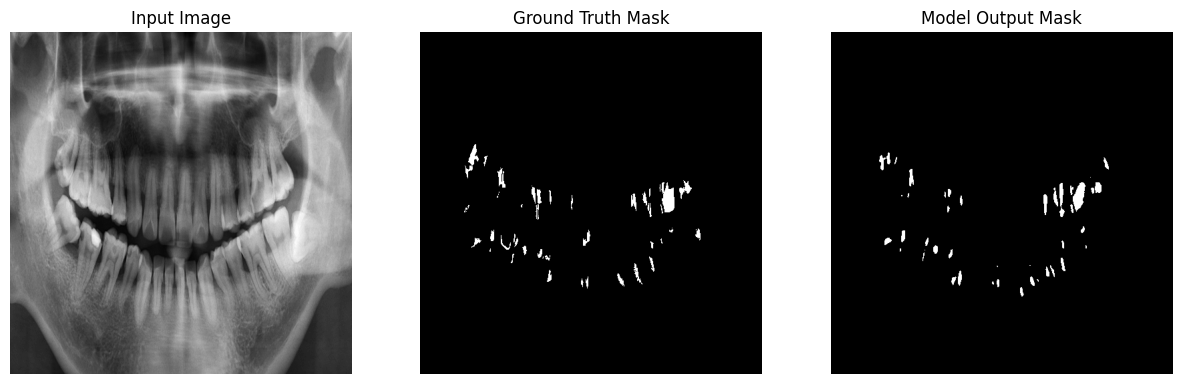

Epoch 202/400
----------


Train Loss (G): 0.1996 | Dice Score: 0.6139


Test Loss (G): 0.2390 | Dice Score: 0.5366
Epoch 203/400
----------


Train Loss (G): 0.2021 | Dice Score: 0.6094


Test Loss (G): 0.2412 | Dice Score: 0.5323
Epoch 204/400
----------


Train Loss (G): 0.1981 | Dice Score: 0.6170


Test Loss (G): 0.2408 | Dice Score: 0.5333
Epoch 205/400
----------


Train Loss (G): 0.1984 | Dice Score: 0.6158


Test Loss (G): 0.2365 | Dice Score: 0.5417
Epoch 206/400
----------


Train Loss (G): 0.2012 | Dice Score: 0.6106


Test Loss (G): 0.2398 | Dice Score: 0.5349
Epoch 207/400
----------


Train Loss (G): 0.2001 | Dice Score: 0.6131


Test Loss (G): 0.2383 | Dice Score: 0.5389
Epoch 208/400
----------


Train Loss (G): 0.1995 | Dice Score: 0.6132


Test Loss (G): 0.2389 | Dice Score: 0.5376
Epoch 209/400
----------


Train Loss (G): 0.1982 | Dice Score: 0.6171


Test Loss (G): 0.2375 | Dice Score: 0.5401
Epoch 210/400
----------


Train Loss (G): 0.1986 | Dice Score: 0.6155


Test Loss (G): 0.2375 | Dice Score: 0.5396
Epoch 211/400
----------


Train Loss (G): 0.1992 | Dice Score: 0.6145
Dice score is 0.010903669521212578


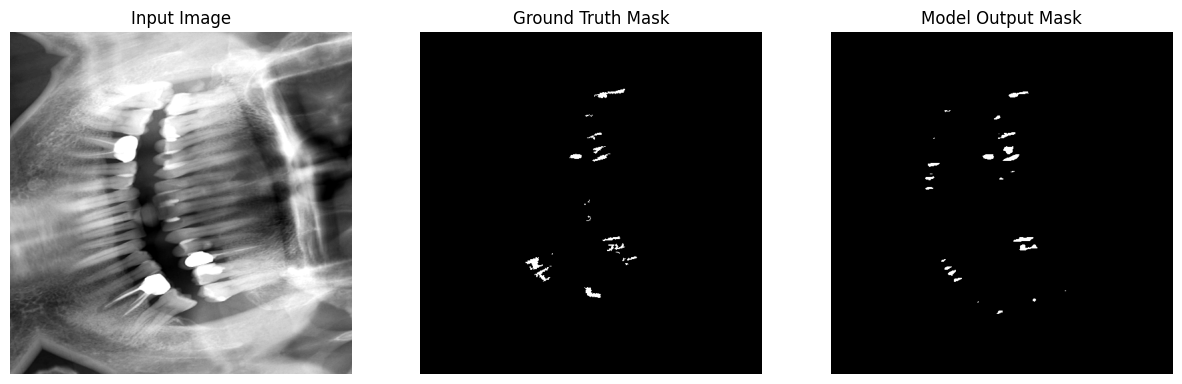

Test Loss (G): 0.2394 | Dice Score: 0.5358
Dice score is 0.024313222616910934


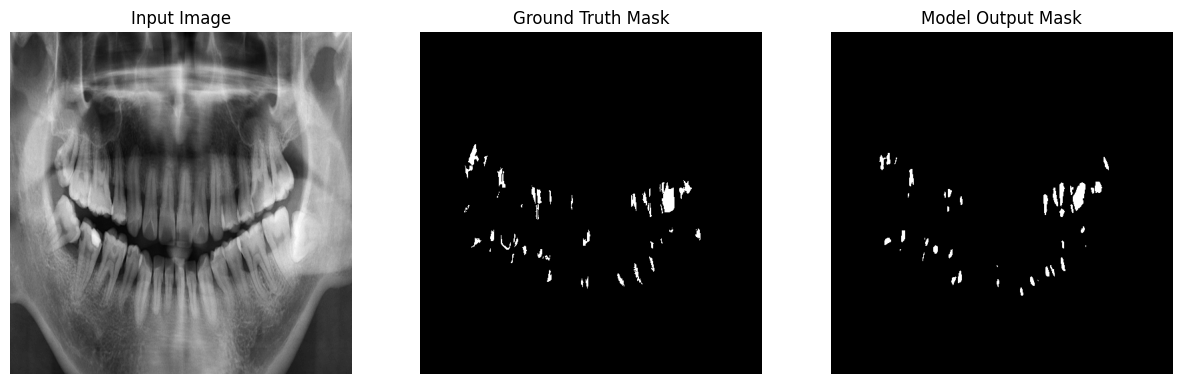

Epoch 212/400
----------


Train Loss (G): 0.1994 | Dice Score: 0.6147


Test Loss (G): 0.2360 | Dice Score: 0.5426
Epoch 213/400
----------


Train Loss (G): 0.1996 | Dice Score: 0.6140


Test Loss (G): 0.2347 | Dice Score: 0.5456
Epoch 214/400
----------


Train Loss (G): 0.1983 | Dice Score: 0.6167


Test Loss (G): 0.2365 | Dice Score: 0.5413
Epoch 215/400
----------


Train Loss (G): 0.2010 | Dice Score: 0.6114


Test Loss (G): 0.2396 | Dice Score: 0.5352
Epoch 216/400
----------


Train Loss (G): 0.1979 | Dice Score: 0.6169


Test Loss (G): 0.2406 | Dice Score: 0.5330
Epoch 217/400
----------


Train Loss (G): 0.1998 | Dice Score: 0.6136


Test Loss (G): 0.2410 | Dice Score: 0.5324
Epoch 218/400
----------


Train Loss (G): 0.1983 | Dice Score: 0.6166


Test Loss (G): 0.2376 | Dice Score: 0.5395
Epoch 219/400
----------


Train Loss (G): 0.1987 | Dice Score: 0.6154


Test Loss (G): 0.2341 | Dice Score: 0.5474
Epoch 220/400
----------


Train Loss (G): 0.1960 | Dice Score: 0.6207


Test Loss (G): 0.2350 | Dice Score: 0.5450
Epoch 221/400
----------


Train Loss (G): 0.1986 | Dice Score: 0.6155
Dice score is 0.01596948318183422


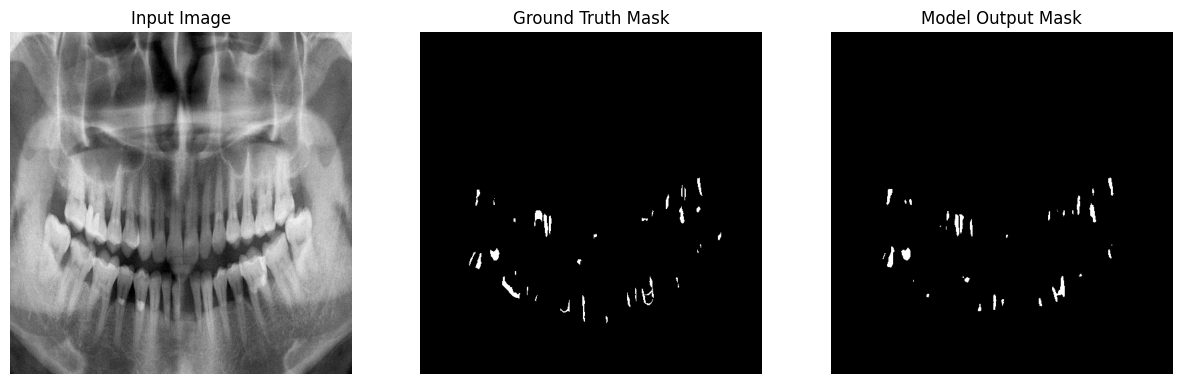

Test Loss (G): 0.2360 | Dice Score: 0.5432
Dice score is 0.024313222616910934


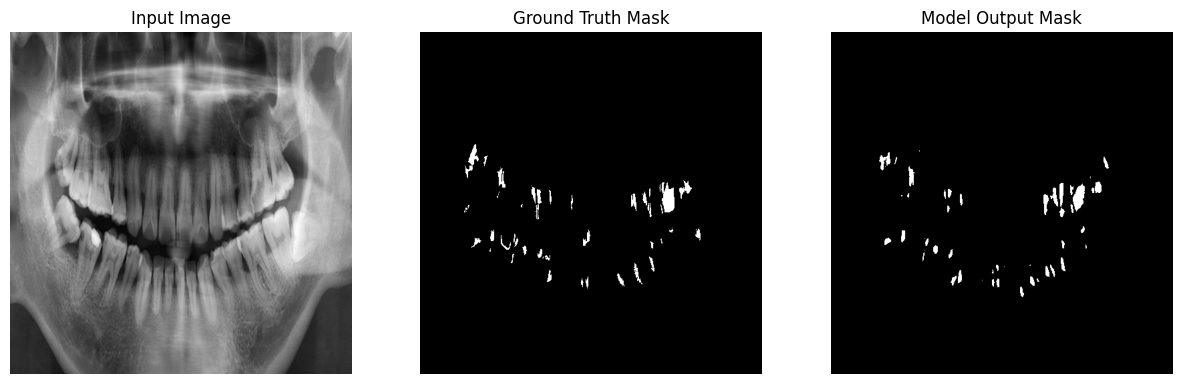

Epoch 222/400
----------


Train Loss (G): 0.1996 | Dice Score: 0.6145


Test Loss (G): 0.2357 | Dice Score: 0.5439
Epoch 223/400
----------


Train Loss (G): 0.1968 | Dice Score: 0.6190


Test Loss (G): 0.2364 | Dice Score: 0.5419
Epoch 224/400
----------


Train Loss (G): 0.1980 | Dice Score: 0.6172


Test Loss (G): 0.2369 | Dice Score: 0.5413
Epoch 225/400
----------


Train Loss (G): 0.1996 | Dice Score: 0.6145


Test Loss (G): 0.2395 | Dice Score: 0.5361
Epoch 226/400
----------


Train Loss (G): 0.1961 | Dice Score: 0.6208


Test Loss (G): 0.2386 | Dice Score: 0.5382
Epoch 227/400
----------


Train Loss (G): 0.1991 | Dice Score: 0.6154


Test Loss (G): 0.2362 | Dice Score: 0.5429
Epoch 228/400
----------


Train Loss (G): 0.2002 | Dice Score: 0.6124


Test Phase:  50%|█████     | 5/10 [00:01<00:01,  4.12it/s]

In [ ]:
train_model(
    generator=model.generator,
    dataloaders=dataloaders,
    optimizer_G=optimizer_G,
    scheduler_G=scheduler_G,
    num_epochs=400,
    device=device
)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation='relu', conv_type='encoder'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm1 = nn.GroupNorm(num_groups=out_channels, num_channels=out_channels)
        self.activation = getattr(F, activation.lower())

        self.conv_type = conv_type
        if conv_type == 'decoder':
            self.conv2 = nn.Conv2d(out_channels, out_channels * 2, kernel_size, stride, padding)
            self.norm2 = nn.GroupNorm(num_groups=out_channels * 2, num_channels=out_channels * 2)
            self.conv3 = nn.Conv2d(out_channels * 2, out_channels, kernel_size, stride, padding)
            self.norm3 = nn.GroupNorm(num_groups=out_channels, num_channels=out_channels)

        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding='same')

    def forward(self, x):
        out = self.activation(self.norm1(self.conv1(x)))
        if self.conv_type == 'decoder':
            out = self.activation(self.norm2(self.conv2(out)))
            out = self.activation(self.norm3(self.conv3(out)))

        residual = self.residual(x)
        out = out + residual
        return self.activation(out)


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation='relu'):
        super().__init__()
        self.conv_block = ConvolutionBlock(in_channels, out_channels, kernel_size, stride, padding, activation)
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        out = self.conv_block(x)
        downsampled = self.pool(out)
        return downsampled, out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation='relu'):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=padding)
        self.conv_block = ConvolutionBlock(out_channels, out_channels, kernel_size, stride, padding, activation, conv_type='decoder')

    def forward(self, x, skip_connection):
        x = self.upconv(x)
        if x.shape[2:] != skip_connection.shape[2:]:
            x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)
        x = (x + skip_connection) / 2
        return self.conv_block(x)


class Model(nn.Module):
    def __init__(self, in_channels=1, base_filters=32, kernel_size=3, stride=1, padding=1):
        super().__init__()
        # Encoder layers
        self.encoder1 = EncoderBlock(in_channels, base_filters, kernel_size, stride, padding, 'leaky_relu')
        self.encoder2 = EncoderBlock(base_filters, base_filters * 2, kernel_size, stride, padding, 'leaky_relu')
        self.encoder3 = EncoderBlock(base_filters * 2, base_filters * 4, kernel_size, stride, padding, 'leaky_relu')
        self.encoder4 = EncoderBlock(base_filters * 4, base_filters * 8, kernel_size, stride, padding, 'leaky_relu')
        self.encoder5 = EncoderBlock(base_filters * 8, base_filters * 16, kernel_size, stride, padding, 'leaky_relu')

        # Decoder layers
        self.decoder1 = DecoderBlock(base_filters * 16, base_filters * 16, kernel_size, stride, padding)
        self.decoder2 = DecoderBlock(base_filters * 8, base_filters * 8, kernel_size, stride, padding)
        self.decoder3 = DecoderBlock(base_filters * 8, base_filters * 4, kernel_size, stride, padding)
        self.decoder4 = DecoderBlock(base_filters * 4, base_filters * 2, kernel_size, stride, padding)
        self.decoder5 = DecoderBlock(base_filters * 2, base_filters, kernel_size, stride, padding)

        # Output layer
        self.output_layer = nn.ConvTranspose2d(base_filters, 1, kernel_size=kernel_size, stride=stride, padding=padding)
        self.sigmoid = nn.Sigmoid()

    ####### DO NOT CHANGE THIS PART ########
    def init(self):
        self.load_state_dict(torch.load('model.pth', weights_only=True))
    ########################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        This method defines the forward pass of the model.

        Args:
            x (tensor): The input tensor, in the shape of (batch_size,1,512,512).

        Returns:
            mask (tensor): The output tensor logits, in the shape of (batch_size,1,512,512).
        """
        # Encoder path
        con1, skip1 = self.encoder1(x)
        con2, skip2 = self.encoder2(con1)
        con3, skip3 = self.encoder3(con2)
        con4, skip4 = self.encoder4(con3)
        con5, skip5 = self.encoder5(con4)

        # Decoder path
        deco = self.decoder1(con5, skip5)
        deco1 = self.decoder2(deco, skip4)
        deco2 = self.decoder3(deco1, skip3)
        deco3 = self.decoder4(deco2, skip2)
        deco4 = self.decoder5(deco3, skip1)

        # Output
        mask = self.sigmoid(self.output_layer(deco4))
        return mask


In [22]:
# Step 2: Initialize the new Model
model = Model(in_channels=1, base_filters=32, kernel_size=3, stride=1, padding=1)

In [21]:
# Step 1: Load the checkpoint and extract generator weights
checkpoint_path = "/kaggle/input/teeth-segment-weights/best_generator_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

/tmp/ipykernel_30/1632226280.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_a

In [23]:
generator_state_dict = checkpoint['generator_state_dict'] 

In [24]:
model.load_state_dict(generator_state_dict, strict=False)

<All keys matched successfully>

In [25]:
torch.save(model.state_dict(), 'model.pth')

In [26]:
model2 = Model(in_channels=1, base_filters=32, kernel_size=3, stride=1, padding=1)

In [27]:
model2.init()

In [28]:
model2

Model(
  (encoder1): EncoderBlock(
    (conv_block): ConvolutionBlock(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
      (residual): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (encoder2): EncoderBlock(
    (conv_block): ConvolutionBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): GroupNorm(64, 64, eps=1e-05, affine=True)
      (residual): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (encoder3): EncoderBlock(
    (conv_block): ConvolutionBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): GroupNorm(128, 128, eps=1e-05, affine=True)
      (residual): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=same)
   